## Problem statement

* Schuster is a multinational retailer of sports goods and garments. It conducts significant business with hundreds of vendors with whom it has arranged a credit arrangement.
* However, not all its vendors respect the credit terms and tend to make late payments. While Schuster imposes a fine for every late payment made by the vendor, but such an approach is not seemingly beneficial for the long-term relationships of either of the parties.
* The collectors (Schuster employees who collect and reconcile the payments against the invoices raised) must keep chasing the vendors to ensure the payment is received on time. In case of late payments, they spend considerable time coordinating the payments. This resulted in many non-value-added activities, loss of time and effort and financial impact on Schuster.

## Payment process at Schuster

* Every time a transaction of goods takes place with these vendors, the accounting team raises an invoice and shares it with the vendor. This invoice contains details of goods, invoice value, creation date and the due date for payment based on the credit term as per the contract.
* Business with these vendors occurs very frequently hence there are always multiple invoices associated with each of these vendors at a given time

## Goal

*	Schuster would like to better understand the customers’ payment behaviour based on their past payment patterns (customer segmentation).
*	Using historical information, it wants to be able to predict the likelihood of delayed payment against open invoices from its customers.
*	It wants to use this information so that collectors can prioritise their work in following up with customers beforehand to get the payments on time.

#### To summarise, as a business analyst, you want to find the answer to these questions:

*	How can we analyse the customer transactions data to find different payment behaviours?
*	In which way can you segregate the customers based on their previous payment patterns/behaviours?
*	Based on the historical data, can you predict the likelihood of delayed payment against open invoices from the customers?
*	Can you draw any business insights based on your developed model?

## Importing Libraries and reading data

In [616]:
# Importing necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from statsmodels.tools.tools import add_constant
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [10]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

## Data Preparation

In [12]:
# Load Received_Payments_Data
data = pd.read_csv('Received_Payments_Data.csv')
data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [13]:
# Display the first few rows to understand the data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

In [14]:
# Check for the missing values
data.isnull().sum()

RECEIPT_METHOD            0
CUSTOMER_NAME             0
CUSTOMER_NUMBER           0
RECEIPT_DOC_NO           29
RECEIPT_DATE              0
CLASS                     0
CURRENCY_CODE             0
Local Amount              0
USD Amount                0
INVOICE_ALLOCATED         0
INVOICE_CREATION_DATE     0
DUE_DATE                  0
PAYMENT_TERM              0
INVOICE_CLASS             0
INVOICE_CURRENCY_CODE     0
INVOICE_TYPE              0
dtype: int64

so we have found that there are 29 missing values in RECEIPT_DOC_NO column

In [16]:
# Summary statistics
data.describe()

,CUSTOMER_NUMBER,RECEIPT_DOC_NO,Local Amount,USD Amount
count,93937.000000,9.390800e+04,9.393700e+04,9.393700e+04
mean,12753.874033,1.583908e+11,1.066470e+06,5.312013e+05
std,14274.170829,3.885359e+10,1.546901e+06,9.508693e+05
min,1044.000000,1.421000e+10,0.000000e+00,0.000000e+00
25%,1888.000000,1.470000e+11,8.198039e+04,3.766298e+04
50%,4003.000000,1.510000e+11,4.053438e+05,1.810010e+05
75%,20884.000000,1.690000e+11,1.425606e+06,5.996137e+05
max,52940.000000,2.970000e+11,1.084983e+07,1.084983e+07


In [17]:
# checking number of unique values in each column
data.nunique()

RECEIPT_METHOD               8
CUSTOMER_NAME              690
CUSTOMER_NUMBER           1054
RECEIPT_DOC_NO              73
RECEIPT_DATE               170
CLASS                        1
CURRENCY_CODE                8
Local Amount              7752
USD Amount                7820
INVOICE_ALLOCATED        12986
INVOICE_CREATION_DATE     1310
DUE_DATE                  1203
PAYMENT_TERM                42
INVOICE_CLASS                3
INVOICE_CURRENCY_CODE       10
INVOICE_TYPE                 2
dtype: int64

In [18]:
# Checking the shape of the data
data.shape

(93937, 16)

In [19]:
# Null counts
round(data.isna().sum()/len(data.index), 4)

RECEIPT_METHOD           0.0000
CUSTOMER_NAME            0.0000
CUSTOMER_NUMBER          0.0000
RECEIPT_DOC_NO           0.0003
RECEIPT_DATE             0.0000
CLASS                    0.0000
CURRENCY_CODE            0.0000
Local Amount             0.0000
USD Amount               0.0000
INVOICE_ALLOCATED        0.0000
INVOICE_CREATION_DATE    0.0000
DUE_DATE                 0.0000
PAYMENT_TERM             0.0000
INVOICE_CLASS            0.0000
INVOICE_CURRENCY_CODE    0.0000
INVOICE_TYPE             0.0000
dtype: float64

* The "RECEIPT_DOC_NO" col has 0.03% null values.Dropping the columns as it is not important for model building

## Cleaning of Data 

In [22]:
# Dropping the "RECEIPT_DOC_NO" column
data.drop('RECEIPT_DOC_NO', axis=1, inplace=True)

# Checking the head of data again
data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [23]:
data.shape

(93937, 15)

In [24]:
# checking dtypes of all the columns 
data.dtypes

RECEIPT_METHOD            object
CUSTOMER_NAME             object
CUSTOMER_NUMBER            int64
RECEIPT_DATE              object
CLASS                     object
CURRENCY_CODE             object
Local Amount             float64
USD Amount               float64
INVOICE_ALLOCATED         object
INVOICE_CREATION_DATE     object
DUE_DATE                  object
PAYMENT_TERM              object
INVOICE_CLASS             object
INVOICE_CURRENCY_CODE     object
INVOICE_TYPE              object
dtype: object

In [25]:
# Changing the date related columns to pandas datatime object

data['RECEIPT_DATE'] = pd.to_datetime(data['RECEIPT_DATE'])
data['INVOICE_CREATION_DATE'] = pd.to_datetime(data['INVOICE_CREATION_DATE'])
data['DUE_DATE'] = pd.to_datetime(data['DUE_DATE'])

In [26]:
# checking dtypes of all the columns 
data.dtypes

RECEIPT_METHOD                   object
CUSTOMER_NAME                    object
CUSTOMER_NUMBER                   int64
RECEIPT_DATE             datetime64[ns]
CLASS                            object
CURRENCY_CODE                    object
Local Amount                    float64
USD Amount                      float64
INVOICE_ALLOCATED                object
INVOICE_CREATION_DATE    datetime64[ns]
DUE_DATE                 datetime64[ns]
PAYMENT_TERM                     object
INVOICE_CLASS                    object
INVOICE_CURRENCY_CODE            object
INVOICE_TYPE                     object
dtype: object

In [27]:
# Using boolean values and converting them into integer to create the target column 'default'
data['default'] = (data["RECEIPT_DATE"] > data["DUE_DATE"]).astype(int)

In [28]:
# Checking the count of defaulted bill payments
data.default.value_counts()

default
1    61978
0    31959
Name: count, dtype: int64

In [29]:
# Checking the percentage of defaulted bill payments
data.default.value_counts(normalize=True)

default
1    0.659783
0    0.340217
Name: proportion, dtype: float64

## Exploratory Data Analysis(EDA)

In [31]:
# Categorical Columns
cat_cols= ['CUSTOMER_NAME','CLASS','CURRENCY_CODE','PAYMENT_TERM','INVOICE_CLASS','INVOICE_CURRENCY_CODE', 'INVOICE_TYPE',
           'RECEIPT_METHOD']

# Numerical Columns
num_cols= ['Local Amount', 'USD Amount']

## Univariate Analysis

### Numerical Columns

In [34]:
# 'Local Amount' column summary
data['Local Amount'].describe().round()

count       93937.0
mean      1066470.0
std       1546901.0
min             0.0
25%         81980.0
50%        405344.0
75%       1425606.0
max      10849829.0
Name: Local Amount, dtype: float64

In [35]:
# Checking the number of bills with Local Amount equal to 0
data[data['Local Amount'] == 0].shape

(1126, 16)

* 1126 bills have amount equal to 0, hence dropping these rows.

In [37]:
# Dropping the rows with 'Local Amount' = 0
data = data[data['Local Amount'] > 0]

# Checking the shape again
data.shape

(92811, 16)

In [38]:
# Checking the summary of 'Local Amount' column again
data['Local Amount'].describe().round()

count       92811.0
mean      1079408.0
std       1551763.0
min             5.0
25%         90577.0
50%        415084.0
75%       1465108.0
max      10849829.0
Name: Local Amount, dtype: float64

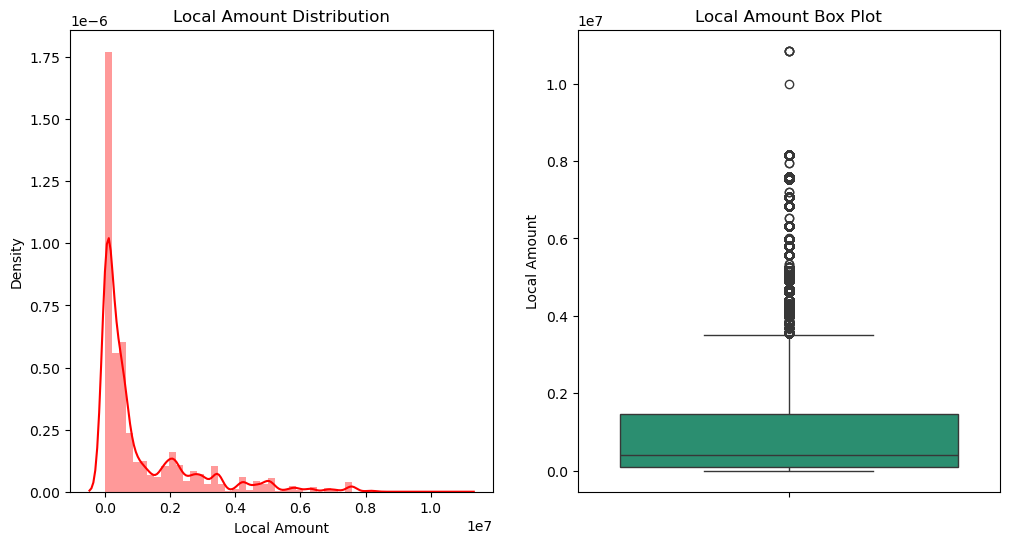

In [39]:
# Visualizing the distribution of 'Local Amount' column

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(data['Local Amount'],color= 'red')
plt.title("Local Amount Distribution")

plt.subplot(1,2,2)
sns.boxplot(data['Local Amount'],palette='Dark2')
plt.title("Local Amount Box Plot")

plt.show()

Dropping the 'Local Amount' column as it does not have a single currency value and we already have 'USD Amount' column for bill amount.

In [41]:
# Dropping the 'Local Amount' column
data.drop('Local Amount', axis=1, inplace=True)

# Checking the head of data
data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,default
0,WIRE,C EA Corp,37403,2021-04-20,PMT,USD,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1
1,WIRE,RADW Corp,4003,2021-01-31,PMT,SAR,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1
2,WIRE,RADW Corp,4003,2021-01-31,PMT,SAR,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0
3,WIRE,FARO Corp,1409,2021-01-31,PMT,SAR,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1
4,WIRE,RADW Corp,4003,2021-01-31,PMT,SAR,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1


In [42]:
# 'USD Amount' column summary
data['USD Amount'].describe().round()

count       92811.0
mean       537646.0
std        954807.0
min             1.0
25%         40453.0
50%        191287.0
75%        599614.0
max      10849829.0
Name: USD Amount, dtype: float64

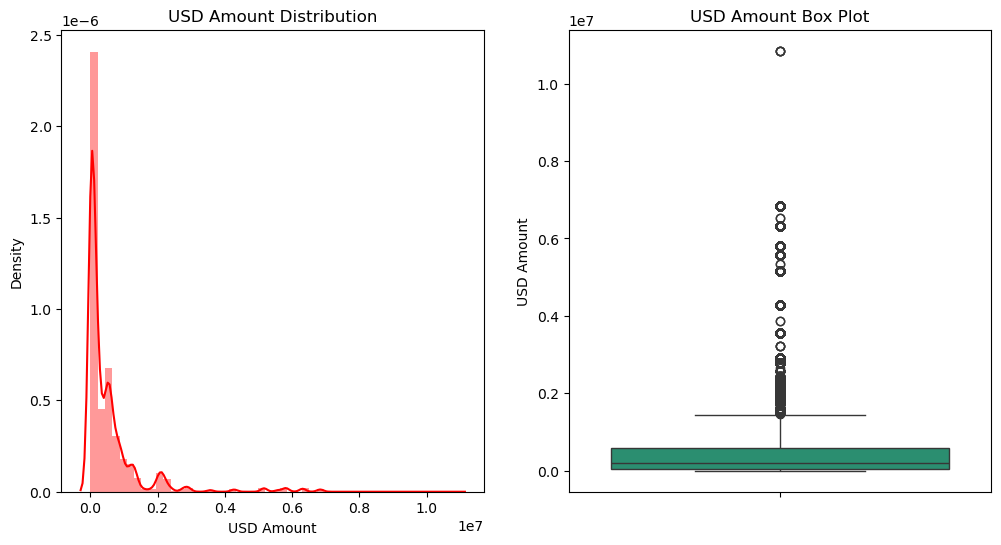

In [43]:
# Visualizing the distribution of 'USD Amount' column

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(data['USD Amount'],color= 'red')
plt.title("USD Amount Distribution")

plt.subplot(1,2,2)
sns.boxplot(data['USD Amount'],palette='Dark2')
plt.title("USD Amount Box Plot")

plt.show()

## Categorical Columns

### CUSTOMER_NAME column

In [46]:
# Finding the number of Unique customer names
data['CUSTOMER_NAME'].nunique()

689

In [47]:
# Top 10 customers on the basis total invoices
data['CUSTOMER_NAME'].value_counts().head(10)

CUSTOMER_NAME
SEPH Corp    23075
FARO Corp    15004
PARF Corp     6624
ALLI Corp     5645
AREE Corp     2224
DEBE Corp     2133
RADW Corp     1647
YOUG Corp     1480
HABC Corp     1402
CARR Corp      952
Name: count, dtype: int64

In [48]:
# Top 10 customers based on the invoice amounts in USD.
data.groupby('CUSTOMER_NAME')['USD Amount'].sum().sort_values(ascending=False).head(10)

CUSTOMER_NAME
SEPH Corp    3.253371e+10
FARO Corp    5.790071e+09
PARF Corp    3.200510e+09
ALLI Corp    2.580741e+09
AREE Corp    1.125144e+09
HABC Corp    5.343216e+08
RADW Corp    3.622376e+08
L OR Corp    2.955509e+08
CGR  Corp    2.795162e+08
PCD  Corp    2.466070e+08
Name: USD Amount, dtype: float64

### CLASS column

In [50]:
# Checking the number of unique values in the column
data['CLASS'].nunique()

1

In [51]:
# Dropping the CLASS column as it has only one value
data.drop('CLASS', axis=1, inplace=True)

In [52]:
data.shape

(92811, 14)

### CURRENCY_CODE column

In [54]:
# Checking the number of unique values in the column
data['CURRENCY_CODE'].nunique()

8

In [55]:
# Checking the value counts of each currency code
data['CURRENCY_CODE'].value_counts()

CURRENCY_CODE
AED    36027
SAR    35784
USD    19361
EUR     1438
GBP      130
BHD       59
KWD       10
QAR        2
Name: count, dtype: int64

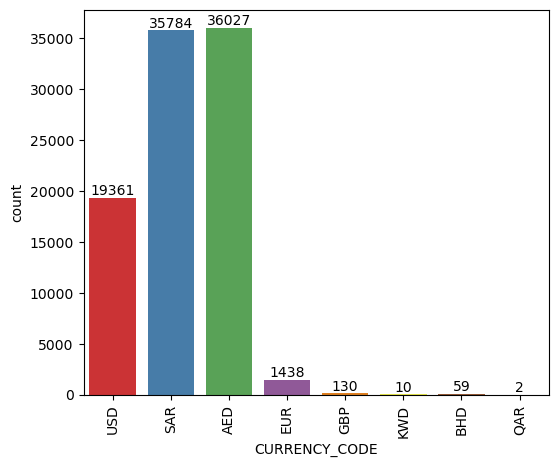

In [56]:
# Visualising the column
plt.figure(figsize=(6,5))
col = sns.countplot(data=data, x='CURRENCY_CODE',palette='Set1')
plt.xticks(rotation= 90)
for label in col.containers:
    col.bar_label(label)
plt.show()

* Currency used for bill payments are mostly USD, SAR or AED.

### PAYMENT_TERM column

In [59]:
# Checking the number of unique values in the column
data['PAYMENT_TERM'].nunique()

42

In [60]:
# Checking the list of unique values in the column
data['PAYMENT_TERM'].unique()

array(['30 Days from EOM', '30 Days from Inv Date', '45 Days from EOM',
       'Immediate', '100% Adv Payment', 'Immediate Payment',
       '15 Days from EOM', '25 DAYS FROM EOM', '60 Days from EOM',
       '60 Days from Inv Date', '45 Days from Inv Date',
       '90 Days from Inv Date', '15 Days from Inv Date',
       'Cash on Delivery', '45 DAYS + EOM', '90 Days from EOM',
       'On Consignment', 'EOM', '7 Days from Inv Date',
       '50% ADVANCE PAYMENT AND 50% UPON RECEIVING THE SHIPMENT',
       '75 Days from EOM', 'Standby LC at 30 days',
       '30% advance 70% after 30 days from invoice date', 'LC at 60 days',
       '50% Advance 50% INVDATE+60 DAYS', '120 Days from EOM',
       '75 Days from Inv Date', 'LCSight', '180 DAYS FROM INV DATE',
       'LC at 90 days', '30% advance 70% after 60 days from invoice date',
       'Cash Against Document at sight', 'Advance with discount',
       '50% ADV 50% 30 Days', '120 Days from Inv Date',
       '25% ADVANCE, 75% 30 DAYS FROM INVOIC

In [61]:
# Checking the top 10 PAYMENT_TERM
data['PAYMENT_TERM'].value_counts().head(10)

PAYMENT_TERM
60 Days from Inv Date    19742
30 Days from Inv Date    14022
60 Days from EOM         12512
30 Days from EOM         11301
15 Days from EOM          7533
Immediate Payment         5468
Immediate                 4946
90 Days from EOM          3893
45 Days from Inv Date     3550
45 Days from EOM          3509
Name: count, dtype: int64

### INVOICE_CLASS column

In [63]:
# Checking the number of unique values in the column
data['INVOICE_CLASS'].nunique()

3

In [64]:
# Checking the value count of each level of INVOICE_CLASS
data['INVOICE_CLASS'].value_counts()

INVOICE_CLASS
INV    87313
CM      4946
DM       552
Name: count, dtype: int64

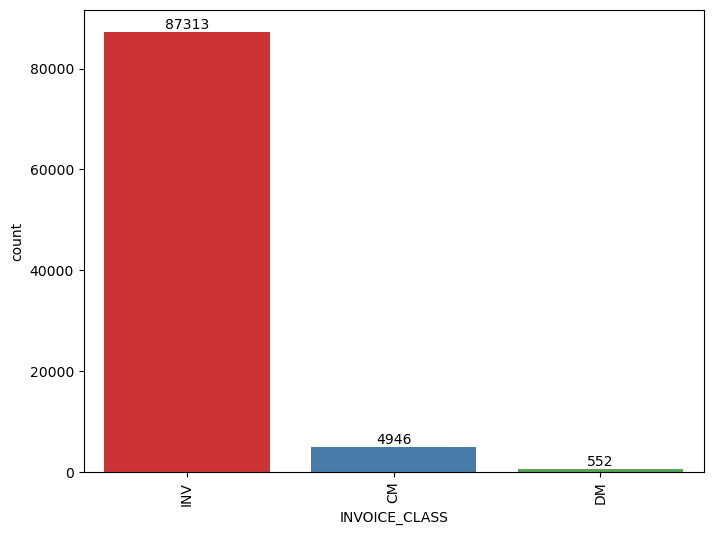

In [65]:
# Visualising the column
plt.figure(figsize=(8,6))
col = sns.countplot(data=data, x='INVOICE_CLASS',palette='Set1')
plt.xticks(rotation= 90)
for label in col.containers:
    col.bar_label(label)
plt.show()

* INV has the maximum number of bills in INVOICE_CLASS column.

### INVOICE_CURRENCY_CODE column

In [68]:
# Checking the number of unique values in the column
data['INVOICE_CURRENCY_CODE'].nunique()

10

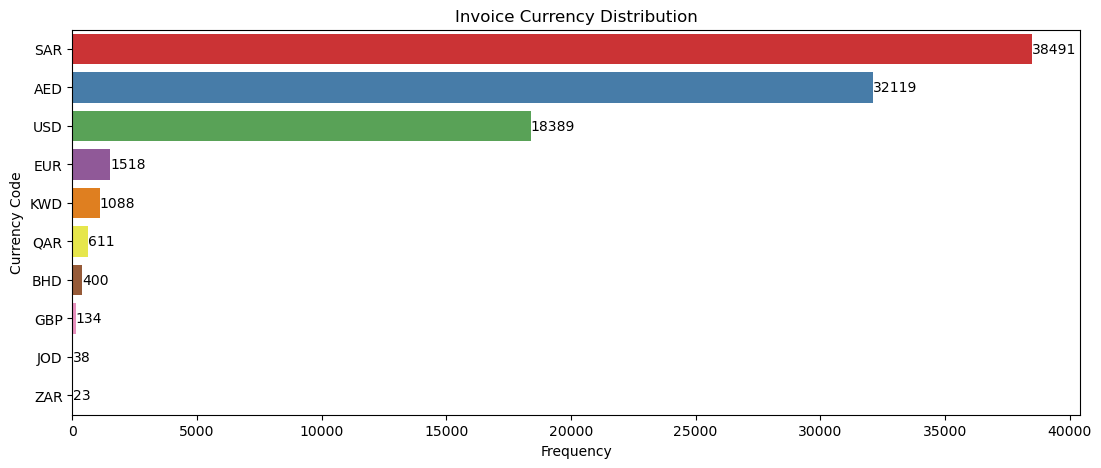

In [69]:

# Visualising the column
plt.figure(figsize=(13,5))

col = sns.countplot(data=data, y='INVOICE_CURRENCY_CODE', order=data['INVOICE_CURRENCY_CODE'].value_counts().index,palette='Set1')
for label in col.containers:
    col.bar_label(label)
    
plt.title("Invoice Currency Distribution")
plt.ylabel("Currency Code")
plt.xlabel("Frequency")

plt.show()

* The most number of invoices were generated in SAR, AED and USD currency.

### INVOICE_TYPE column

In [72]:
# Checking the number of unique values in the column
data['INVOICE_TYPE'].nunique()

2

In [73]:
# Checking the value count of each level of INVOICE_TYPE
data['INVOICE_TYPE'].value_counts()

INVOICE_TYPE
Goods        66569
Non Goods    26242
Name: count, dtype: int64

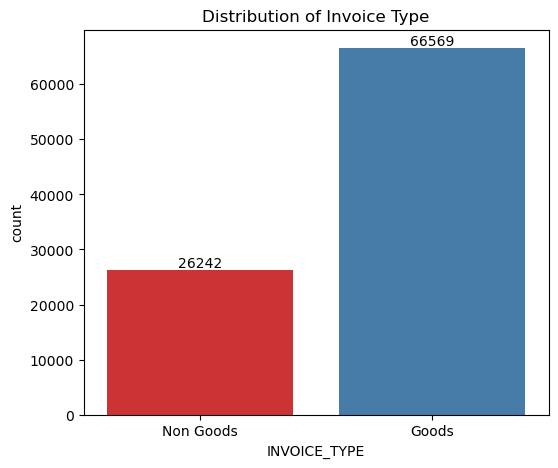

In [74]:
# Visualising the column
plt.figure(figsize=(6,5))
col = sns.countplot(data=data, x='INVOICE_TYPE',palette='Set1')
for label in col.containers:
    col.bar_label(label)
    
plt.title("Distribution of Invoice Type")
plt.show()

* Almost 70% of the invoices generated were for Goods products.

### RECEIPT_METHOD column

In [77]:
# Checking the value count of each level of RECEIPT_METHOD
data['RECEIPT_METHOD'].value_counts()

RECEIPT_METHOD
WIRE             83281
AP/AR Netting     4847
CHEQUE            3472
CASH               782
I/C WIRE           211
PDC                210
I/C Check            6
I/C CASH             2
Name: count, dtype: int64

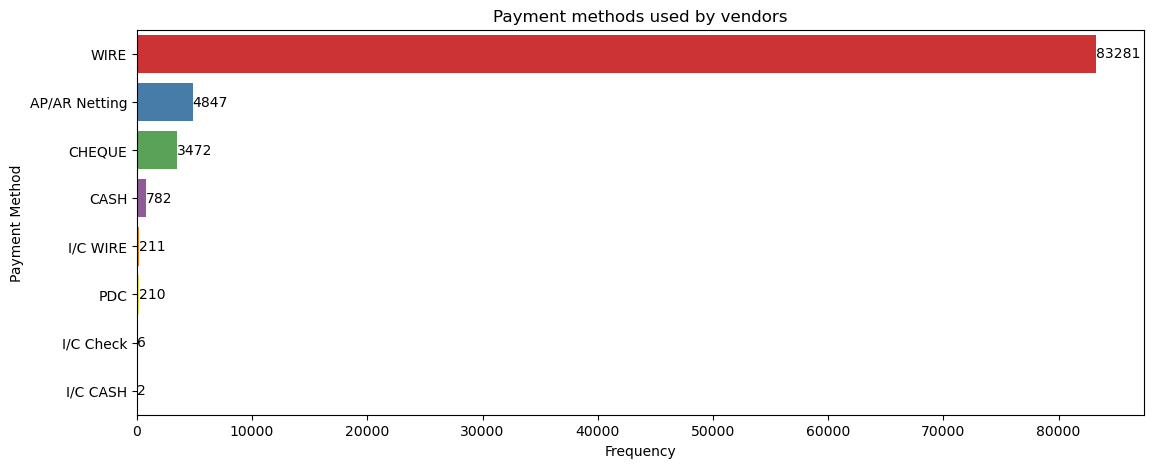

In [78]:
# Visualising the column
plt.figure(figsize=(13,5))

col = sns.countplot(data=data, y='RECEIPT_METHOD', order=data['RECEIPT_METHOD'].value_counts().index,palette='Set1')
for label in col.containers:
    col.bar_label(label)
    
plt.title("Payment methods used by vendors")
plt.ylabel("Payment Method")
plt.xlabel("Frequency")

plt.show()

* The most preferred payment method for bill payment is WIRE.

## Data Imbalance

In [81]:
# Checking the distribution of target column 'default'
data["default"].value_counts(normalize= True)

default
1    0.656528
0    0.343472
Name: proportion, dtype: float64

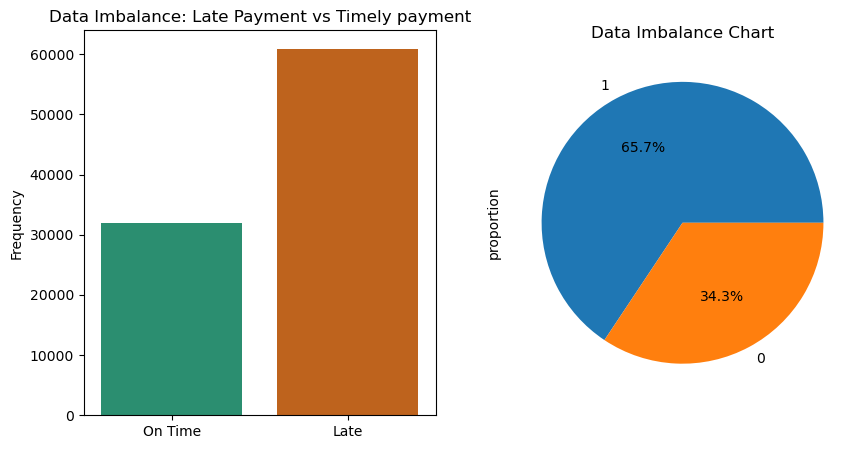

In [82]:
# ploting the default column
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.countplot(x='default', data=data,palette="Dark2")

plt.title("Data Imbalance: Late Payment vs Timely payment")
plt.xlabel("")
plt.ylabel("Frequency")
plt.xticks((0,1), ('On Time', 'Late'))

plt.subplot(1,2,2)

#data imbalance chart
(data.default.value_counts(normalize = True)*100).plot.pie(autopct='%1.1f%%')
plt.title("Data Imbalance Chart")

plt.show()

* There is a good distribution of data in the target variable.

## Bi-variate Analysis

In [85]:
# Extracting month from the date columns

data['month_reciept'] = data['RECEIPT_DATE'].dt.month
data['month_inv_creation'] = data['INVOICE_CREATION_DATE'].dt.month
data['month_due'] = data['DUE_DATE'].dt.month

In [86]:
# Month-wise invoices due

orders_due_month = data.groupby('month_due').count()['DUE_DATE']
orders_due_month

month_due
1     13295
2     12893
3     14605
4     14051
5     13321
6     10479
7      1523
8      1075
9       914
10     1579
11     2875
12     6201
Name: DUE_DATE, dtype: int64

In [87]:
# Effect of monthly due on late payment rate

# Creating a pivot table to see the effects of different months on percentage of late payments
late_dues = data.groupby('month_due')['default'].mean()
late_dues.sort_index(ascending= True)

month_due
1     0.716134
2     0.688048
3     0.620199
4     0.620454
5     0.559643
6     0.416070
7     0.363099
8     0.793488
9     0.974836
10    0.999367
11    1.000000
12    0.999839
Name: default, dtype: float64

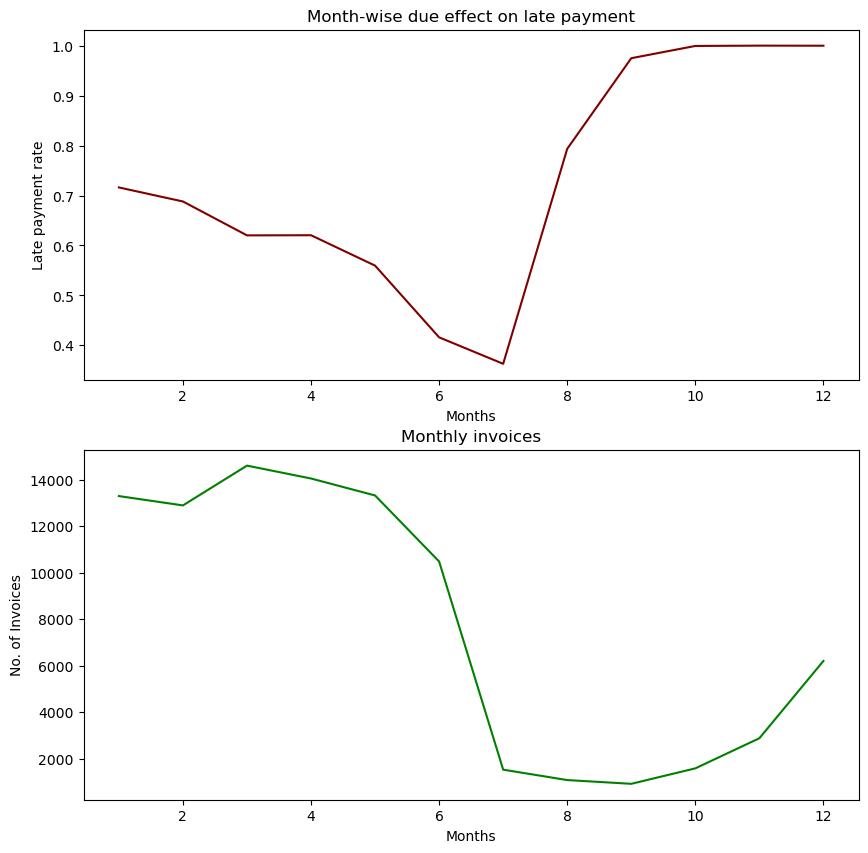

In [88]:
# Visualising the effect of month on late payment rate

plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(late_dues, color='maroon')
plt.title("Month-wise due effect on late payment")
plt.xlabel("Months")
plt.ylabel("Late payment rate")

plt.subplot(2,1,2)
plt.plot(orders_due_month, color='green')
plt.title("Monthly invoices")
plt.xlabel("Months")
plt.ylabel("No. of Invoices")

plt.show()

* For the 3rd month, the number of invoices is the highest and late payment rate is comparatively lower than other months with large number of invoices.
* Month 7 has the very low late payment rate, this can be because of the fact that the number of invoices is also low.
* In the 2nd half of the year, the late payment increases steeply from 7th month onwards. The number of invoices are comparatively lower than the first half of the year.

In [90]:
# Receipt_date

order_month_receipt = data.groupby('month_reciept').count()['DUE_DATE']  # number of payments received in a month

# out of all the payments received in month how many were late payments
monthly_receipt = data.groupby('month_due')['default'].mean()

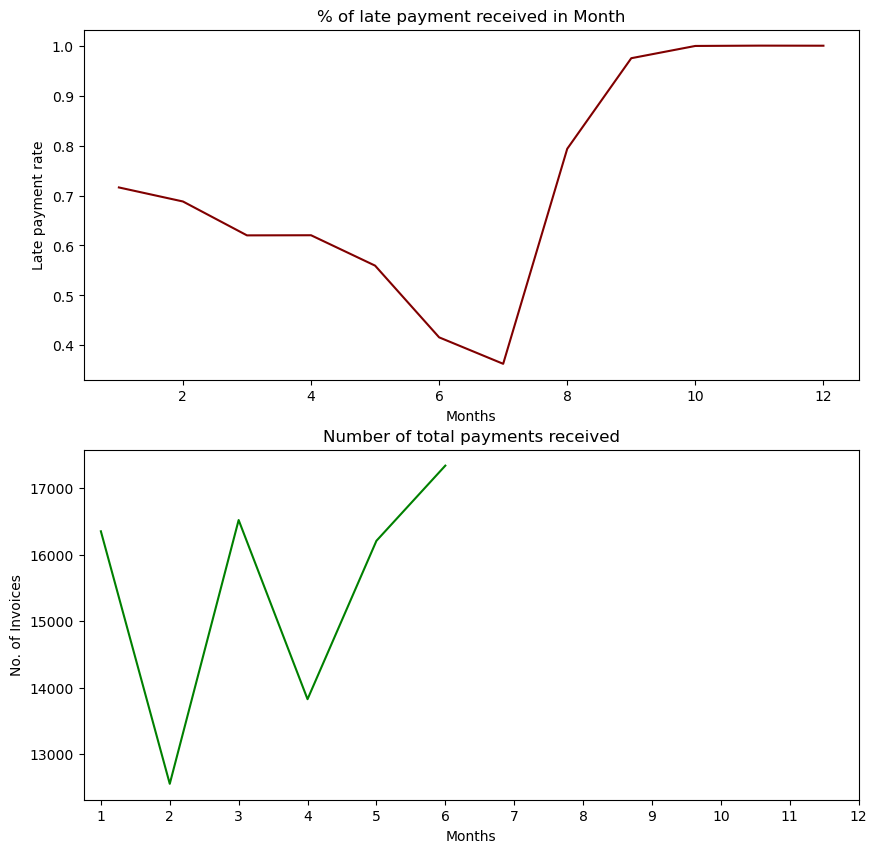

In [91]:
# Visualizing the effect of month in which the invoice is due, on the late payment rate
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(monthly_receipt, color='maroon')
plt.title("% of late payment received in Month")
plt.xlabel("Months")
plt.ylabel("Late payment rate")

plt.subplot(2,1,2)
plt.plot(order_month_receipt, color='green')
plt.title("Number of total payments received")
plt.xticks([i for i in range(1,13,1)])
plt.xlabel("Months")
plt.ylabel("No. of Invoices")

plt.show()

* No payment received against any invoices from 7th month onwards.

In [93]:
# invoice creation date

orders_month_created = data.groupby('month_inv_creation').count()['DUE_DATE']  # number of invoices generated in month

month_created = data.groupby('month_inv_creation')['default'].mean() # out of all the invoices created % of late payment

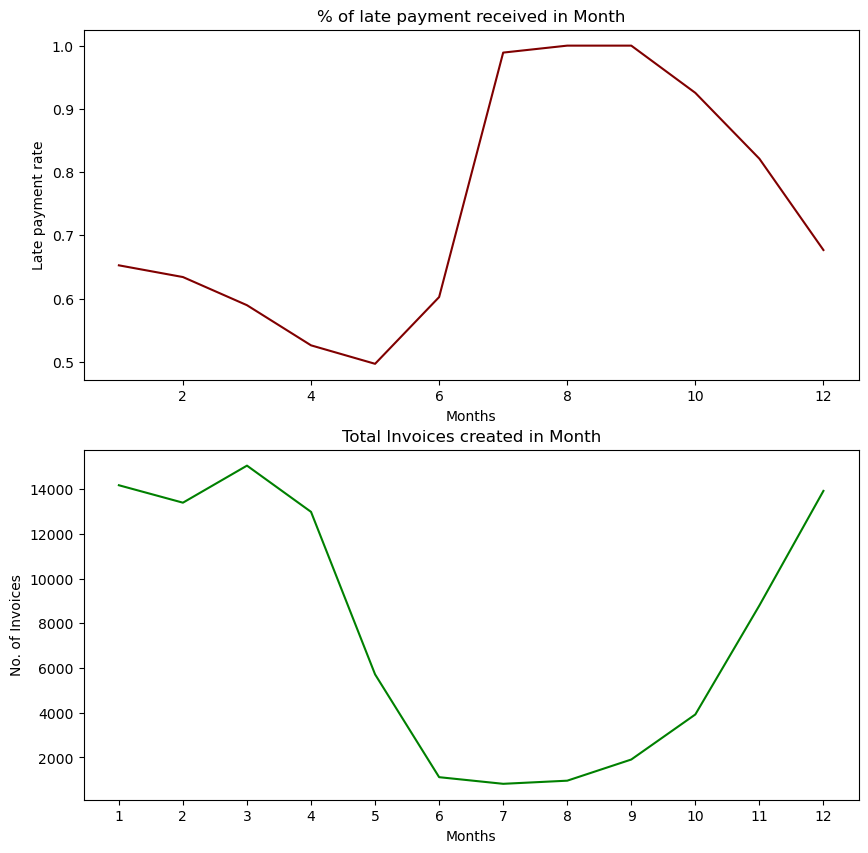

In [94]:
# Visualizing the effect of months in which the invoice is due, on the late payment rate
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(month_created, color='maroon')
plt.title("% of late payment received in Month")
plt.xlabel("Months")
plt.ylabel("Late payment rate")

plt.subplot(2,1,2)
plt.plot(orders_month_created, color='green')
plt.title("Total Invoices created in Month")
plt.xticks([i for i in range(1,13,1)])
plt.xlabel("Months")
plt.ylabel("No. of Invoices")

plt.show()

* Late payment rate is decreases from 1st to 5th month.
* For the months 7, 8 and 9, the late payment rate is very high.

### USD Amount column

In [97]:
usd_amt_late = data.pivot_table(values='USD Amount', index='default', aggfunc=['mean', 'median', np.std]).reset_index()
usd_amt_late

,default,mean,median,std
,,USD Amount,USD Amount,USD Amount
0,0,575247.544230,224785.0410,879205.782363
1,1,517974.153529,165499.3105,991505.462081


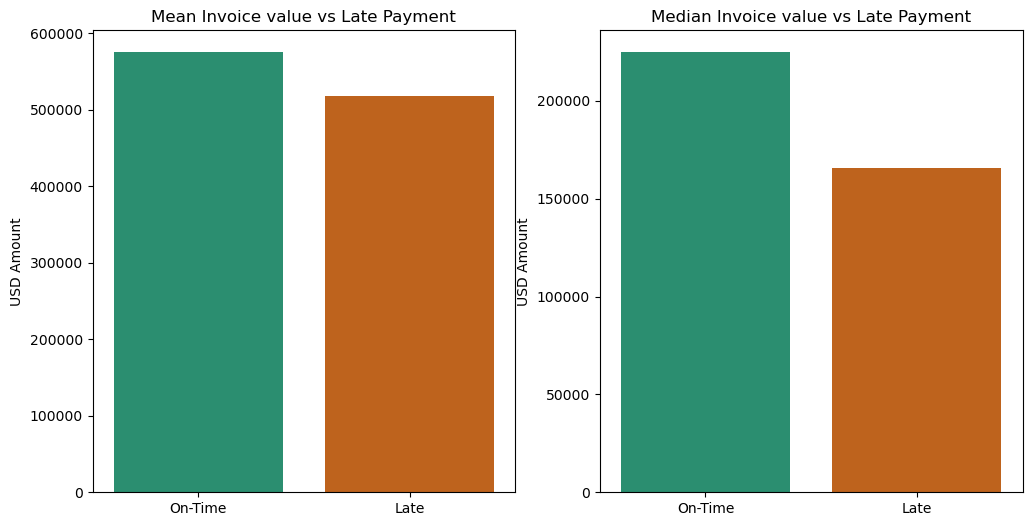

In [98]:
# Visualising the differencing between mean and median of the invoice value with respect to late payment

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)

sns.barplot(data=usd_amt_late, x='default', y=('mean','USD Amount'),palette='Dark2')
plt.xticks((0,1), ('On-Time', 'Late'))
plt.title("Mean Invoice value vs Late Payment")
plt.xlabel("")
plt.ylabel("USD Amount")

plt.subplot(1,2,2)

sns.barplot(data=usd_amt_late, x='default', y=('median','USD Amount'),palette="Dark2")
plt.xticks((0,1), ('On-Time', 'Late'))
plt.title("Median Invoice value vs Late Payment")
plt.xlabel("")
plt.ylabel("USD Amount")

plt.show()

* The mean and median of invoice value of On-time bill payment is higher than late payment.

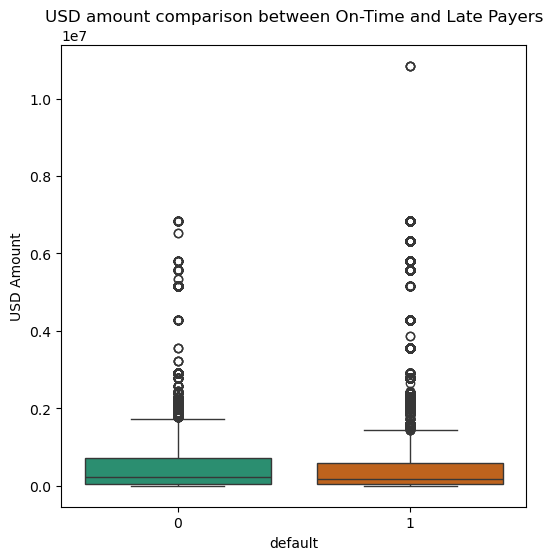

In [100]:
plt.figure(figsize=(6,6))

sns.boxplot(y = 'USD Amount', x='default', data = data,palette='Dark2')
plt.title("USD amount comparison between On-Time and Late Payers")

plt.show()

### CUSTOMER_NAME column

In [102]:
customer_total_orders = data.groupby('CUSTOMER_NAME').count()['default'].sort_values(ascending=False).reset_index()
customer_total_orders_late = data.groupby('CUSTOMER_NAME')['default'].mean().sort_values(ascending=False).reset_index()

In [103]:
# Finding the important customers (customers with more than 500 orders)

imp_cust = customer_total_orders[customer_total_orders['default'] > 500]['CUSTOMER_NAME']
imp_cust

0     SEPH Corp
1     FARO Corp
2     PARF Corp
3     ALLI Corp
4     AREE Corp
5     DEBE Corp
6     RADW Corp
7     YOUG Corp
8     HABC Corp
9     CARR Corp
10    AL T Corp
11    VAVA Corp
12    CGR  Corp
13    REAL Corp
14    PARI Corp
15    ARAB Corp
16    LIFE Corp
17    AL S Corp
18    MCT  Corp
19    CWF  Corp
20    AL F Corp
21    CHRI Corp
Name: CUSTOMER_NAME, dtype: object

In [104]:
# Checking only important customers late payment rate

imp_cust_late = customer_total_orders_late[customer_total_orders_late['CUSTOMER_NAME'].isin(imp_cust)]
imp_cust_late

,CUSTOMER_NAME,default
201,YOUG Corp,1.000000
246,VAVA Corp,0.937873
256,AL T Corp,0.917241
273,LIFE Corp,0.899522
287,PARI Corp,0.876153
306,PARF Corp,0.847222
308,AL S Corp,0.842788
341,CHRI Corp,0.787276
342,CARR Corp,0.786765
380,HABC Corp,0.726106


### INVOICE_CLASS column

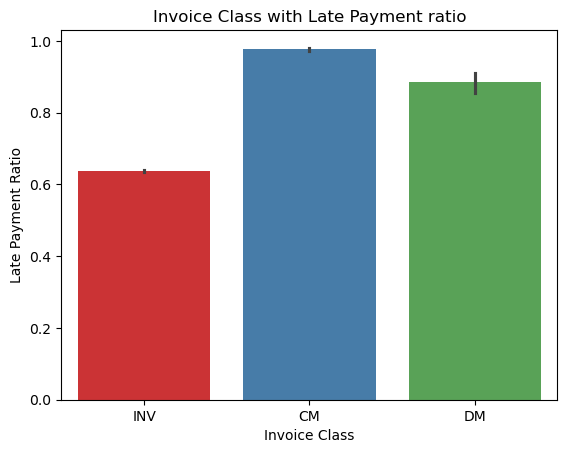

In [106]:
# Visualising the late payment ratio of each invoice class

sns.barplot(data=data, x='INVOICE_CLASS', y='default', estimator=np.mean,palette='Set1')
plt.title("Invoice Class with Late Payment ratio")
plt.xlabel("Invoice Class")
plt.ylabel("Late Payment Ratio")
plt.show()

*Late payment ratio is very high for CM and lowest for INV INVOICE_CLASS.

### INVOICE_TYPE class

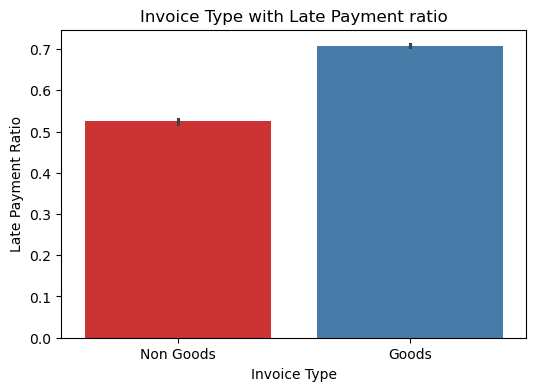

In [109]:
# Visualising the late payment ratio of each Invoice Type
plt.figure(figsize=(6,4))

sns.barplot(data=data, x='INVOICE_TYPE', y='default', estimator=np.mean,palette='Set1')
plt.title("Invoice Type with Late Payment ratio")
plt.xlabel("Invoice Type")
plt.ylabel("Late Payment Ratio")
plt.show()

* Late payment ratio for Goods is higher than Non-Goods.

## Feature Engineering

### PAYMENT_TERM column

In [113]:
# Using cumsum() function to get cummulative sum on value_counts()

pay_term_cumsum = data['PAYMENT_TERM'].value_counts(normalize=True).cumsum()
pay_term_cumsum

PAYMENT_TERM
60 Days from Inv Date                                      0.212712
30 Days from Inv Date                                      0.363793
60 Days from EOM                                           0.498605
30 Days from EOM                                           0.620368
15 Days from EOM                                           0.701533
Immediate Payment                                          0.760449
Immediate                                                  0.813740
90 Days from EOM                                           0.855685
45 Days from Inv Date                                      0.893935
45 Days from EOM                                           0.931743
90 Days from Inv Date                                      0.955566
100% Adv Payment                                           0.968905
25 DAYS FROM EOM                                           0.973882
Cash on Delivery                                           0.978386
15 Days from Inv Date              

In [114]:
# Both Immediate and Immediate payment are same, hence replacing with Immediate Payment

data['PAYMENT_TERM'] = data['PAYMENT_TERM'].replace('Immediate', 'Immediate Payment')

# 45 Days from EOM and 45 DAYS + EOM are giving same information, hence using 45 Days from EOM
data['PAYMENT_TERM'] = data['PAYMENT_TERM'].replace('45 DAYS + EOM', '45 Days from EOM')

pay_term_cumsum = data['PAYMENT_TERM'].value_counts(normalize=True).cumsum()
pay_term_cumsum

PAYMENT_TERM
60 Days from Inv Date                                      0.212712
30 Days from Inv Date                                      0.363793
60 Days from EOM                                           0.498605
30 Days from EOM                                           0.620368
Immediate Payment                                          0.732575
15 Days from EOM                                           0.813740
90 Days from EOM                                           0.855685
45 Days from EOM                                           0.896963
45 Days from Inv Date                                      0.935212
90 Days from Inv Date                                      0.959035
100% Adv Payment                                           0.972374
25 DAYS FROM EOM                                           0.977352
Cash on Delivery                                           0.981856
15 Days from Inv Date                                      0.985691
On Consignment                     

* As it can be seen, around 95% of data is covered by 10 values, hence we will club the rest of the values to others in both datasets.

In [116]:
# Top 10 values to keep
vals_to_keep= pay_term_cumsum.index[:10]

# Clubbing the rest values to others
data['PAYMENT_TERM'] = data['PAYMENT_TERM'].apply(lambda x : x if x in vals_to_keep else 'others')

data['PAYMENT_TERM'].value_counts() # Sanity Check

PAYMENT_TERM
60 Days from Inv Date    19742
30 Days from Inv Date    14022
60 Days from EOM         12512
30 Days from EOM         11301
Immediate Payment        10414
15 Days from EOM          7533
90 Days from EOM          3893
45 Days from EOM          3831
others                    3802
45 Days from Inv Date     3550
90 Days from Inv Date     2211
Name: count, dtype: int64

### Dummy Variable

In [118]:
# Creating dummy variables for the 'PAYMENT_TERM' column

term_dummies= pd.get_dummies(data['PAYMENT_TERM']).drop('others', axis=1)

data = data.join(term_dummies).drop('PAYMENT_TERM', axis=1 )
data.shape # Sanity Check

(92811, 26)

In [119]:
# Creating dummy variables for the 'INVOICE_CLASS' column

class_dummies= pd.get_dummies(data['INVOICE_CLASS'])
class_dummies
data = data.join(class_dummies).drop('INVOICE_CLASS', axis=1 )

In [120]:
data.shape

(92811, 28)

In [121]:
data.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'CUSTOMER_NUMBER', 'RECEIPT_DATE',
       'CURRENCY_CODE', 'USD Amount', 'INVOICE_ALLOCATED',
       'INVOICE_CREATION_DATE', 'DUE_DATE', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'default', 'month_reciept', 'month_inv_creation',
       'month_due', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'CM', 'DM', 'INV'],
      dtype='object')

## Open Invoice Data

### Reading and understanding the data

In [124]:
# Reading the open invoice dataset
open_data = pd.read_csv("Open_Invoice_data.csv", encoding='latin1')
open_data.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [125]:
open_data.shape

(88204, 14)

In [126]:
# Removing unecessary columns (that are not there in the receiced payment dataset)
# Dropping 'Transaction Number','Customer Account No' as they bear no significance for our target var.
# Dropping 'Local amount'

open_data.drop(['AS_OF_DATE','Customer Type','Transaction Date','Transaction Currency','Transaction Number',
              'Customer Account No','Local Amount'], axis= 1, inplace= True)

In [127]:
open_data.shape

(88204, 7)

In [128]:
open_data.head()

,Customer_Name,Payment Term,Due Date,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,GIVE Corp,Immediate,21/12/2021,CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,AL J Corp,30 Days from Inv Date,03/03/2022,INVOICE,33,"2,000",2/1/2022 14:09
2,AL J Corp,30 Days from Inv Date,23/04/2022,INVOICE,-18,"2,000",3/24/2022 17:46
3,AL R Corp,15 Days from Inv Date,19/01/2022,INVOICE,76,"2,415",1/5/2022 11:49
4,ALLI Corp,30 Days from EOM,30/04/2022,INVOICE,-25,"3,800",3/3/2022 22:30


In [129]:
# Checking the info of the data
open_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Customer_Name      88204 non-null  object
 1   Payment Term       88204 non-null  object
 2   Due Date           88204 non-null  object
 3   Transaction Class  88204 non-null  object
 4   AGE                88204 non-null  int64 
 5   USD Amount         88204 non-null  object
 6   INV_CREATION_DATE  88204 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.7+ MB


In [130]:
# Checking for null values
open_data.isnull().sum()

Customer_Name        0
Payment Term         0
Due Date             0
Transaction Class    0
AGE                  0
USD Amount           0
INV_CREATION_DATE    0
dtype: int64

* No null values present in the dataset.

In [132]:
# Changing the format of 'Due Date' and 'INV_CREATION_DATE' to pandas datetime
open_data['Due Date'] = pd.to_datetime(open_data['Due Date'])
open_data['INV_CREATION_DATE'] = pd.to_datetime(open_data['INV_CREATION_DATE'])

In [133]:
open_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Customer_Name      88204 non-null  object        
 1   Payment Term       88204 non-null  object        
 2   Due Date           88204 non-null  datetime64[ns]
 3   Transaction Class  88204 non-null  object        
 4   AGE                88204 non-null  int64         
 5   USD Amount         88204 non-null  object        
 6   INV_CREATION_DATE  88204 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 4.7+ MB


In [134]:
# Checking the different values present in USD Amount column
open_data['USD Amount'].unique()

array(['-3,088', '2,000', '2,415', ..., '-914', '12,866', '18,118'],
      dtype=object)

In [135]:
# Changing the datatype of USD Amount
open_data['USD Amount'] = open_data['USD Amount'].apply(lambda x: x.replace(",", ""))
open_data['USD Amount'] = open_data['USD Amount'].astype(int)

In [136]:
# Checking the USD Amount column again
open_data['USD Amount']

0        -3088
1         2000
2         2000
3         2415
4         3800
         ...  
88199    -1199
88200     -914
88201    12866
88202    18118
88203    18499
Name: USD Amount, Length: 88204, dtype: int64

* There are negative values present in the column, hence it is safe to remove negative and 0 values.

In [138]:
# Keeping the values above 0 for USD Amount column
open_data = open_data[open_data['USD Amount']>0]

In [139]:
# Checking the info of the data set
open_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79516 entries, 1 to 88203
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Customer_Name      79516 non-null  object        
 1   Payment Term       79516 non-null  object        
 2   Due Date           79516 non-null  datetime64[ns]
 3   Transaction Class  79516 non-null  object        
 4   AGE                79516 non-null  int64         
 5   USD Amount         79516 non-null  int64         
 6   INV_CREATION_DATE  79516 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 4.9+ MB


## Feature Engineering

### Payment Term column

In [142]:
# Keeping the same levels as done in recieved payment dataset
open_data['Payment Term'] = open_data['Payment Term'].apply(lambda x: x if x in vals_to_keep else 'others')

open_data['Payment Term'].value_counts()

Payment Term
30 Days from Inv Date    18328
60 Days from Inv Date    17599
Immediate Payment        16202
60 Days from EOM          8170
others                    5385
30 Days from EOM          5324
90 Days from EOM          2595
90 Days from Inv Date     2429
45 Days from Inv Date     1533
15 Days from EOM          1097
45 Days from EOM           854
Name: count, dtype: int64

In [143]:
# Creating dummy variables for the column
term_dummies_open = pd.get_dummies(open_data['Payment Term']).drop('others', axis=1).astype(int)

# Merging the dummies dataframe into open_data and removing the 'Payment Term' column
open_data = open_data.join(term_dummies_open).drop('Payment Term', axis=1)
open_data.head()

,Customer_Name,Due Date,Transaction Class,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment
1,AL J Corp,2022-03-03,INVOICE,33,2000,2022-02-01 14:09:00,0,0,1,0,0,0,0,0,0,0
2,AL J Corp,2022-04-23,INVOICE,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0
3,AL R Corp,2022-01-19,INVOICE,76,2415,2022-01-05 11:49:00,0,0,0,0,0,0,0,0,0,0
4,ALLI Corp,2022-04-30,INVOICE,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0
5,ALLI Corp,2022-04-30,INVOICE,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0


### Transaction Class column

In [145]:
# Checking the levels in the column
open_data['Transaction Class'].value_counts()

Transaction Class
INVOICE       78251
DEBIT NOTE     1265
Name: count, dtype: int64

In [146]:
# Replacing INVOICE with INV and DEBIT NOTE WITH DM
open_data['Transaction Class'] = open_data['Transaction Class'].map(lambda x: 'INV' if x=='INVOICE' else 'DM')

In [147]:
# Creating dummy variables for the column
tc = pd.get_dummies(open_data['Transaction Class']).astype(int)

# Adding the dummy variables to main dataset and dropping the Transaction Class column
open_data = open_data.join(tc).drop('Transaction Class', axis=1)

# Adding 'CM' level to the open_data dataset same as received payment data
open_data['CM'] = 0

In [148]:
# Checking the head of the data
open_data.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM
1,AL J Corp,2022-03-03,33,2000,2022-02-01 14:09:00,0,0,1,0,0,0,0,0,0,0,0,1,0
2,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0
3,AL R Corp,2022-01-19,76,2415,2022-01-05 11:49:00,0,0,0,0,0,0,0,0,0,0,0,1,0
4,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0
5,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0


### Checking columns in received payment dataset and open invoice dataset

In [150]:
data.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'CUSTOMER_NUMBER', 'RECEIPT_DATE',
       'CURRENCY_CODE', 'USD Amount', 'INVOICE_ALLOCATED',
       'INVOICE_CREATION_DATE', 'DUE_DATE', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'default', 'month_reciept', 'month_inv_creation',
       'month_due', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'CM', 'DM', 'INV'],
      dtype='object')

In [151]:
open_data.columns

Index(['Customer_Name', 'Due Date', 'AGE', 'USD Amount', 'INV_CREATION_DATE',
       '15 Days from EOM', '30 Days from EOM', '30 Days from Inv Date',
       '45 Days from EOM', '45 Days from Inv Date', '60 Days from EOM',
       '60 Days from Inv Date', '90 Days from EOM', '90 Days from Inv Date',
       'Immediate Payment', 'DM', 'INV', 'CM'],
      dtype='object')

## Customer Segmentation

It is recommended that customer-level attributes be considered as important independent variables in the model. These attributes can be derived through customer segmentation, which can be performed using two key metrics: the average payment time (in days) and the standard deviation of payment time for each customer. By applying clustering techniques to these variables, distinct customer segments can be identified. These segments can then serve as valuable input features for the machine learning model, potentially enhancing its predictive accuracy and providing deeper insights into customer behavior.

In [154]:
# Creating a new column to show actual number of days taken to make the payment after invoice generation
data['act_days_for_pay'] = (data['RECEIPT_DATE']- data['INVOICE_CREATION_DATE']).dt.days

In [155]:
# Calculating customer wise average days for payment
cust_seg1= data.groupby('CUSTOMER_NAME')['act_days_for_pay'].mean()
cust_seg1 = cust_seg1.to_frame()
cust_seg1.reset_index
cust_seg1.rename(columns={'act_days_for_pay': 'Avg days for payment'}, inplace=True)
cust_seg1.head()

,Avg days for payment
CUSTOMER_NAME,
3D D Corp,24.395349
6TH Corp,40.666667
A3 D Corp,45.400000
ABC Corp,16.000000
ABDU Corp,76.906250


In [156]:
# Calculating the standard deviation for customer wise payment days
cust_seg2 = data.groupby('CUSTOMER_NAME')['act_days_for_pay'].std()
cust_seg2 = cust_seg2.to_frame()
cust_seg2.reset_index
cust_seg2.rename(columns={'act_days_for_pay': 'Std deviation for payment'}, inplace=True)
cust_seg2.head()

,Std deviation for payment
CUSTOMER_NAME,
3D D Corp,13.040449
6TH Corp,7.952987
A3 D Corp,52.581366
ABC Corp,0.000000
ABDU Corp,54.919326


In [157]:
# Merging the above two dataframes
cust_seg = pd.merge(cust_seg1, cust_seg2, how='inner', on='CUSTOMER_NAME')

# Checking the head
cust_seg.head()

,Avg days for payment,Std deviation for payment
CUSTOMER_NAME,,
3D D Corp,24.395349,13.040449
6TH Corp,40.666667,7.952987
A3 D Corp,45.400000,52.581366
ABC Corp,16.000000,0.000000
ABDU Corp,76.906250,54.919326


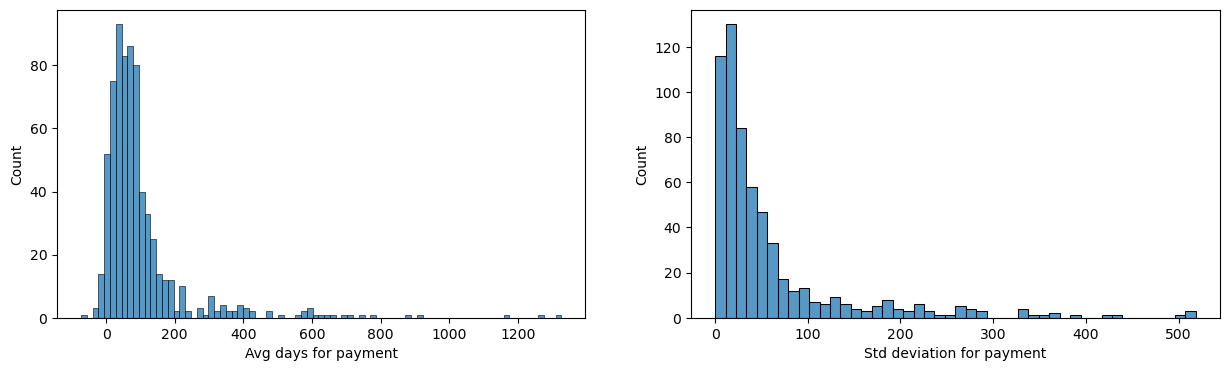

In [158]:
# Visualising the cust_seg dataframe
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
sns.histplot(cust_seg['Avg days for payment'])

plt.subplot(1,2,2)
sns.histplot(cust_seg['Std deviation for payment'])

plt.show()

* From the above plots we can see that the data is not normalized, hence need to do scaling.

In [160]:
# importing required library
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
cust_seg[['Avg days for payment', 'Std deviation for payment']] = scaler.fit_transform(cust_seg[['Avg days for payment', 'Std deviation for payment']])

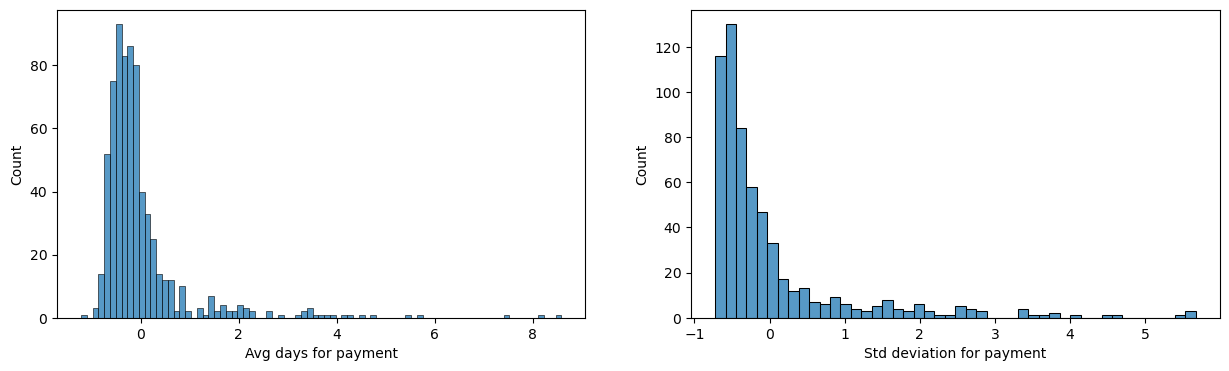

In [161]:
# Visualising the data again
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
sns.histplot(cust_seg['Avg days for payment'])

plt.subplot(1,2,2)
sns.histplot(cust_seg['Std deviation for payment'])

plt.show()

In [162]:
# resetting the index
cust_seg.reset_index(inplace=True)

# Checking the null values if present
round(cust_seg.isna().sum()/len(cust_seg.index), 4)

CUSTOMER_NAME                0.0000
Avg days for payment         0.0000
Std deviation for payment    0.1248
dtype: float64

In [163]:
# Replacing the null values for Std deviation for payment with 0
cust_seg['Std deviation for payment'].fillna(0,inplace=True)

In [164]:
# copying the cust_seg data for clustering into new dataframe
cluster_df = cust_seg.copy()
cluster_df.head()

,CUSTOMER_NAME,Avg days for payment,Std deviation for payment
0,3D D Corp,-0.534519,-0.563303
1,6TH Corp,-0.420640,-0.626042
2,A3 D Corp,-0.387513,-0.075683
3,ABC Corp,-0.593276,-0.724119
4,ABDU Corp,-0.167009,-0.046851


In [165]:
# Dropping customer_name for clustering
cluster_df.drop('CUSTOMER_NAME',axis=1,inplace=True)
cluster_df.head()

,Avg days for payment,Std deviation for payment
0,-0.534519,-0.563303
1,-0.420640,-0.626042
2,-0.387513,-0.075683
3,-0.593276,-0.724119
4,-0.167009,-0.046851


## Clustering

In [167]:
# Importing required libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [168]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=42)
kmeans.fit(cluster_df)
kmeans.cluster_centers_

array([[ 1.85344423,  3.33339499],
       [-0.3019069 , -0.32884213],
       [ 4.66736808,  0.44512922],
       [ 0.42465258,  0.94746544]])

### Finding optimal number of clusters

In [170]:
# Silhouette analysis
cluster_range = [2, 3, 4, 5, 6, 7, 8]

for cluster in cluster_range:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=cluster, max_iter=50, random_state=42)
    kmeans.fit(cluster_df)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(cluster_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(cluster, silhouette_avg))

For n_clusters=2, the silhouette score is 0.7557759850933141
For n_clusters=3, the silhouette score is 0.7491797445652462
For n_clusters=4, the silhouette score is 0.6097388985555463
For n_clusters=5, the silhouette score is 0.6173540681032771
For n_clusters=6, the silhouette score is 0.3980238443004184
For n_clusters=7, the silhouette score is 0.4012628375918799
For n_clusters=8, the silhouette score is 0.41457849738976615


* From the above results, we can see that for 3 clusters, the silhouette score is decent. Hence selecting n_clusters as 3.

In [172]:
# final model with n_clusters=3
kmeans = KMeans(n_clusters=3, max_iter=50, random_state=42)
kmeans.fit(cluster_df)

KMeans(max_iter=50, n_clusters=3, random_state=42)

In [173]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [174]:
# Assigning labels to the cust_seg dataframe
cust_seg['cluster_id'] = kmeans.labels_
cust_seg.head()

,CUSTOMER_NAME,Avg days for payment,Std deviation for payment,cluster_id
0,3D D Corp,-0.534519,-0.563303,1
1,6TH Corp,-0.420640,-0.626042,1
2,A3 D Corp,-0.387513,-0.075683,1
3,ABC Corp,-0.593276,-0.724119,1
4,ABDU Corp,-0.167009,-0.046851,1


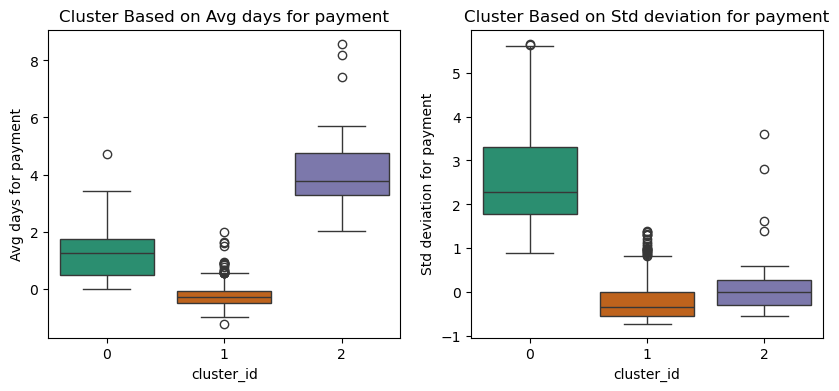

In [175]:
# Plotting box plot based on clusters
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='cluster_id', y='Avg days for payment', data=cust_seg,palette= 'Dark2')
plt.title("Cluster Based on Avg days for payment")


plt.subplot(1,2,2)
sns.boxplot(x='cluster_id', y='Std deviation for payment', data=cust_seg,palette= 'Dark2')
plt.title("Cluster Based on Std deviation for payment")
plt.show()

* '1' Cluster -- Prolonged Invoice Payment

* '2' Cluster -- Early Invoice Payment

* '0' Cluster -- Medium Invoice Payment

In [177]:
# Dropping the 'Avg days for payment' and 'Std deviation for payment' columns for merging this dataset with open invoice 
# dataset to assign cluster id to each customers

cust_seg.drop(['Avg days for payment', 'Std deviation for payment'], axis=1, inplace=True)

In [178]:
# Creating a copy
cust_dict = cust_seg.copy()

In [179]:
# Renaming the column
cust_dict.rename(columns={'CUSTOMER_NAME':'Customer_Name'}, inplace=True)

cust_dict.head()

,Customer_Name,cluster_id
0,3D D Corp,1
1,6TH Corp,1
2,A3 D Corp,1
3,ABC Corp,1
4,ABDU Corp,1


In [180]:
# Setting the 'Customer_Name' as index
cust_dict.set_index('Customer_Name')

,cluster_id
Customer_Name,
3D D Corp,1
6TH Corp,1
A3 D Corp,1
ABC Corp,1
ABDU Corp,1
...,...
YOUS Corp,1
ZAHR Corp,1
ZAIN Corp,1


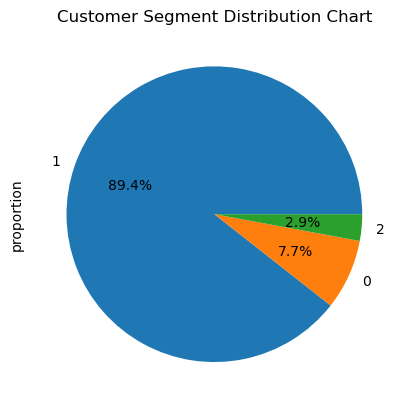

In [181]:
# Visualization
(cust_dict.cluster_id.value_counts(normalize = True)*100).plot.pie(autopct='%1.1f%%')
plt.title("Customer Segment Distribution Chart")
plt.show()

Where

* '1' Cluster -- Prolonged Invoice Payment

* '2' Cluster -- Early Invoice Payment

* '0' Cluster -- Medium Invoice Payment

-- From the above we can see that Early customers comprise of 88.7% of customers whereas medium and prolonged payers are 11.3% in total

In [184]:
# Merging data and cust_deg to add clustering index

merged_df = pd.merge(data, cust_seg, how='inner', on='CUSTOMER_NAME')

# Convert boolean columns to integers (1/0)
bool_columns = [
    '15 Days from EOM', '30 Days from EOM', '30 Days from Inv Date', 
    '45 Days from EOM', '45 Days from Inv Date', '60 Days from EOM', 
    '60 Days from Inv Date', '90 Days from EOM', '90 Days from Inv Date', 
    'Immediate Payment', 'CM', 'DM', 'INV'
]

merged_df[bool_columns] = merged_df[bool_columns].astype(int)

# Display the first few rows of the modified DataFrame
merged_df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,INVOICE_CURRENCY_CODE,INVOICE_TYPE,default,month_reciept,month_inv_creation,month_due,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,CM,DM,INV,act_days_for_pay,cluster_id
0,WIRE,C EA Corp,37403,2021-04-20,USD,101018.63040,14200000001,2020-11-02,2020-12-30,AED,Non Goods,1,4,11,12,0,1,0,0,0,0,0,0,0,0,0,0,1,169,1
1,WIRE,RADW Corp,4003,2021-01-31,SAR,48990.21133,99200000043,2020-12-29,2021-01-28,SAR,Non Goods,1,1,12,1,0,0,1,0,0,0,0,0,0,0,0,0,1,33,1
2,WIRE,RADW Corp,4003,2021-01-31,SAR,41991.60971,99210000003,2021-01-30,2021-03-01,SAR,Non Goods,0,1,1,3,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1
3,WIRE,FARO Corp,1409,2021-01-31,SAR,41991.60971,99200000038,2020-12-15,2021-01-14,SAR,Non Goods,1,1,12,1,0,0,1,0,0,0,0,0,0,0,0,0,1,47,0
4,WIRE,RADW Corp,4003,2021-01-31,SAR,41991.60971,99200000039,2020-12-15,2021-01-14,SAR,Non Goods,1,1,12,1,0,0,1,0,0,0,0,0,0,0,0,0,1,47,1


In [185]:
# checking null values for clusters
merged_df['cluster_id'].isnull().sum()

0

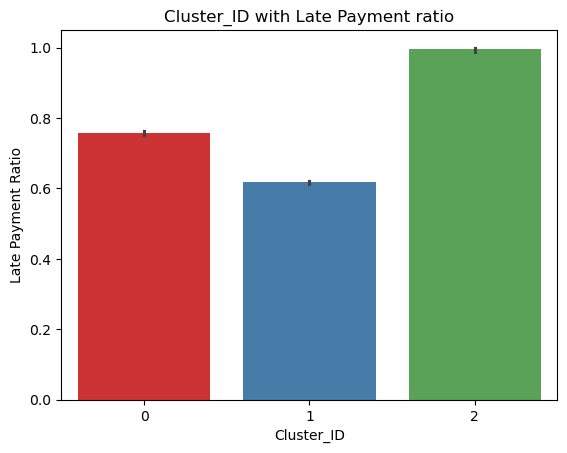

In [186]:
# Visualization 
sns.barplot(data=merged_df, x='cluster_id', y='default', estimator=np.mean, palette='Set1')
plt.title("Cluster_ID with Late Payment ratio")
plt.xlabel("Cluster_ID")
plt.ylabel("Late Payment Ratio")
plt.show()

In [187]:
merged_df.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'CUSTOMER_NUMBER', 'RECEIPT_DATE',
       'CURRENCY_CODE', 'USD Amount', 'INVOICE_ALLOCATED',
       'INVOICE_CREATION_DATE', 'DUE_DATE', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'default', 'month_reciept', 'month_inv_creation',
       'month_due', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'CM', 'DM', 'INV',
       'act_days_for_pay', 'cluster_id'],
      dtype='object')

## Data Preparation for Model building

In [189]:
# Creating a new dataframe with important variables for model building

df = merged_df[['USD Amount','INVOICE_CREATION_DATE', '15 Days from EOM', '30 Days from EOM', 
                    '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date', '60 Days from EOM', 
                    '60 Days from Inv Date', '90 Days from EOM', '90 Days from Inv Date', 'Immediate Payment', 
                    'DM', 'INV', 'CM','cluster_id']]
df.head()

,USD Amount,INVOICE_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id
0,101018.63040,2020-11-02,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1,48990.21133,2020-12-29,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,41991.60971,2021-01-30,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,41991.60971,2020-12-15,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,41991.60971,2020-12-15,0,0,1,0,0,0,0,0,0,0,0,1,0,1


In [190]:
# Creating Invoice_Month column and dropping INVOICE_CREATION_DATE
df['Invoice_Month'] = df['INVOICE_CREATION_DATE'].dt.month
df.drop('INVOICE_CREATION_DATE',axis=1,inplace= True)
df.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
0,101018.63040,0,1,0,0,0,0,0,0,0,0,0,1,0,1,11
1,48990.21133,0,0,1,0,0,0,0,0,0,0,0,1,0,1,12
2,41991.60971,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1
3,41991.60971,0,0,1,0,0,0,0,0,0,0,0,1,0,0,12
4,41991.60971,0,0,1,0,0,0,0,0,0,0,0,1,0,1,12


In [191]:
df.shape

(92811, 16)

In [192]:
# Open Invoice dataset
open_df = open_data[['Due Date','USD Amount', 'INV_CREATION_DATE', '15 Days from EOM', '30 Days from EOM', 
                         '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date', '60 Days from EOM',
                         '60 Days from Inv Date', '90 Days from EOM', '90 Days from Inv Date', 'Immediate Payment', 
                         'DM', 'INV', 'CM','AGE']]
open_df.head()

,Due Date,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,AGE
1,2022-03-03,2000,2022-02-01 14:09:00,0,0,1,0,0,0,0,0,0,0,0,1,0,33
2,2022-04-23,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,-18
3,2022-01-19,2415,2022-01-05 11:49:00,0,0,0,0,0,0,0,0,0,0,0,1,0,76
4,2022-04-30,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,-25
5,2022-04-30,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,-25


In [193]:
# Creating Invoice_Month column and dropping INV_CREATION_DATE
open_df['Invoice_Month'] = open_df['INV_CREATION_DATE'].dt.month
open_df.drop('INV_CREATION_DATE',axis=1,inplace= True)

open_df.head()

,Due Date,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,AGE,Invoice_Month
1,2022-03-03,2000,0,0,1,0,0,0,0,0,0,0,0,1,0,33,2
2,2022-04-23,2000,0,0,1,0,0,0,0,0,0,0,0,1,0,-18,3
3,2022-01-19,2415,0,0,0,0,0,0,0,0,0,0,0,1,0,76,1
4,2022-04-30,3800,0,1,0,0,0,0,0,0,0,0,0,1,0,-25,3
5,2022-04-30,1264,0,1,0,0,0,0,0,0,0,0,0,1,0,-25,3


In [194]:
# Creating Due_Month column and dropping Due Date
open_df['Due_Month'] = open_df['Due Date'].dt.month
open_df.drop('Due Date',axis=1,inplace= True)

open_df.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,AGE,Invoice_Month,Due_Month
1,2000,0,0,1,0,0,0,0,0,0,0,0,1,0,33,2,3
2,2000,0,0,1,0,0,0,0,0,0,0,0,1,0,-18,3,4
3,2415,0,0,0,0,0,0,0,0,0,0,0,1,0,76,1,1
4,3800,0,1,0,0,0,0,0,0,0,0,0,1,0,-25,3,4
5,1264,0,1,0,0,0,0,0,0,0,0,0,1,0,-25,3,4


In [195]:
# Checking columns for both datasets
open_df.columns

Index(['USD Amount', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'DM', 'INV', 'CM', 'AGE',
       'Invoice_Month', 'Due_Month'],
      dtype='object')

In [196]:
df.columns

Index(['USD Amount', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'DM', 'INV', 'CM',
       'cluster_id', 'Invoice_Month'],
      dtype='object')

## Train - Test Split

In [329]:
# Feature variables X
X = df.copy()
X.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
0,101018.63040,0,1,0,0,0,0,0,0,0,0,0,1,0,1,11
1,48990.21133,0,0,1,0,0,0,0,0,0,0,0,1,0,1,12
2,41991.60971,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1
3,41991.60971,0,0,1,0,0,0,0,0,0,0,0,1,0,0,12
4,41991.60971,0,0,1,0,0,0,0,0,0,0,0,1,0,1,12


In [331]:
# Target variable y
y = merged_df['default']
y.head()

0    1
1    1
2    0
3    1
4    1
Name: default, dtype: int64

In [333]:
# Splitting into train and test set
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=42)
X_train.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
52625,10110.77468,0,1,0,0,0,0,0,0,0,0,0,1,0,1,5
29115,20469.08000,0,0,0,0,0,0,1,0,0,0,0,1,0,1,4
80920,19816.98173,0,0,0,0,0,0,0,1,0,0,1,0,0,1,12
55019,655652.78150,0,0,0,0,0,1,0,0,0,0,0,1,0,1,12
82266,268512.93000,0,0,0,0,0,0,1,0,0,0,0,1,0,1,12


## Feature Scaling

In [336]:
X_train.shape

(64967, 16)

In [338]:
# Feature scaling for USD amount
scaler = StandardScaler()
X_train['USD Amount'] = scaler.fit_transform(X_train[['USD Amount']])

X_train.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
52625,-0.553331,0,1,0,0,0,0,0,0,0,0,0,1,0,1,5
29115,-0.542467,0,0,0,0,0,0,1,0,0,0,0,1,0,1,4
80920,-0.543151,0,0,0,0,0,0,0,1,0,0,1,0,0,1,12
55019,0.123734,0,0,0,0,0,1,0,0,0,0,0,1,0,1,12
82266,-0.282310,0,0,0,0,0,0,1,0,0,0,0,1,0,1,12


In [340]:
X_train.describe()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
count,6.496700e+04,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000,64967.000000
mean,-4.702901e-18,0.080487,0.121154,0.151369,0.042052,0.037973,0.135115,0.211892,0.042314,0.024289,0.112057,0.006142,0.940831,0.053027,0.731679,5.455354
std,1.000008e+00,0.272048,0.326308,0.358411,0.200710,0.191133,0.341849,0.408652,0.201306,0.153947,0.315439,0.078128,0.235942,0.224089,0.448407,4.073434
min,-5.639339e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-5.215070e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
50%,-3.638550e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,4.000000
75%,6.495879e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.000000
max,1.081571e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,12.000000


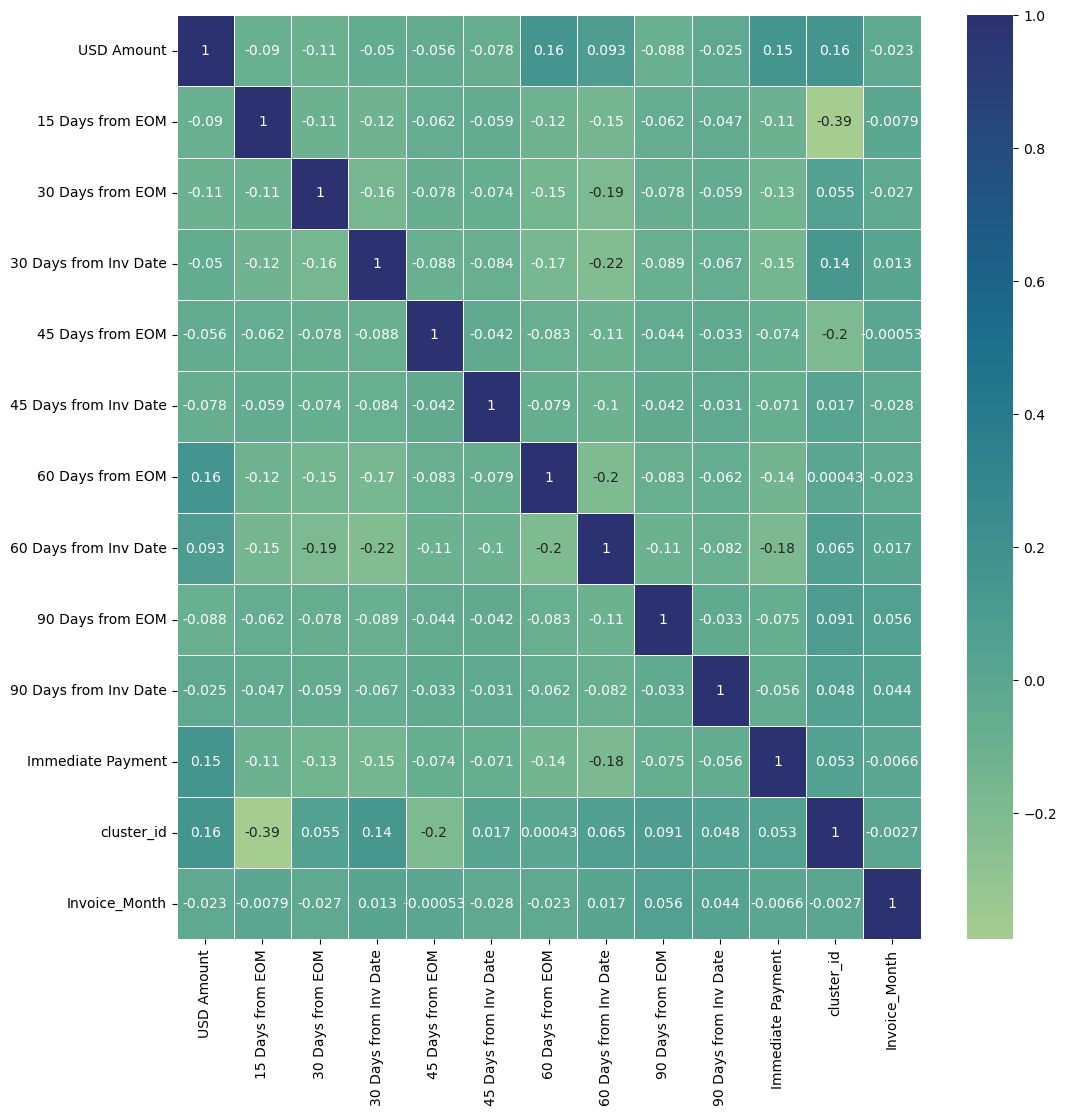

In [360]:
# Plotting heat map of X_train dataset
plt.figure(figsize=(12,12))
sns.heatmap(X_train.corr(), annot=True,linewidths= 0.5 ,cmap= 'crest')
plt.show()

* CM & INV, INV & Immediate Payment, DM & 90 days from EOM has high multicollinearity, hence dropping these columns.

In [345]:
X_train.drop(['CM', 'INV', 'DM'], axis=1, inplace=True)
X_test.drop(['CM', 'INV', 'DM'], axis=1, inplace=True)

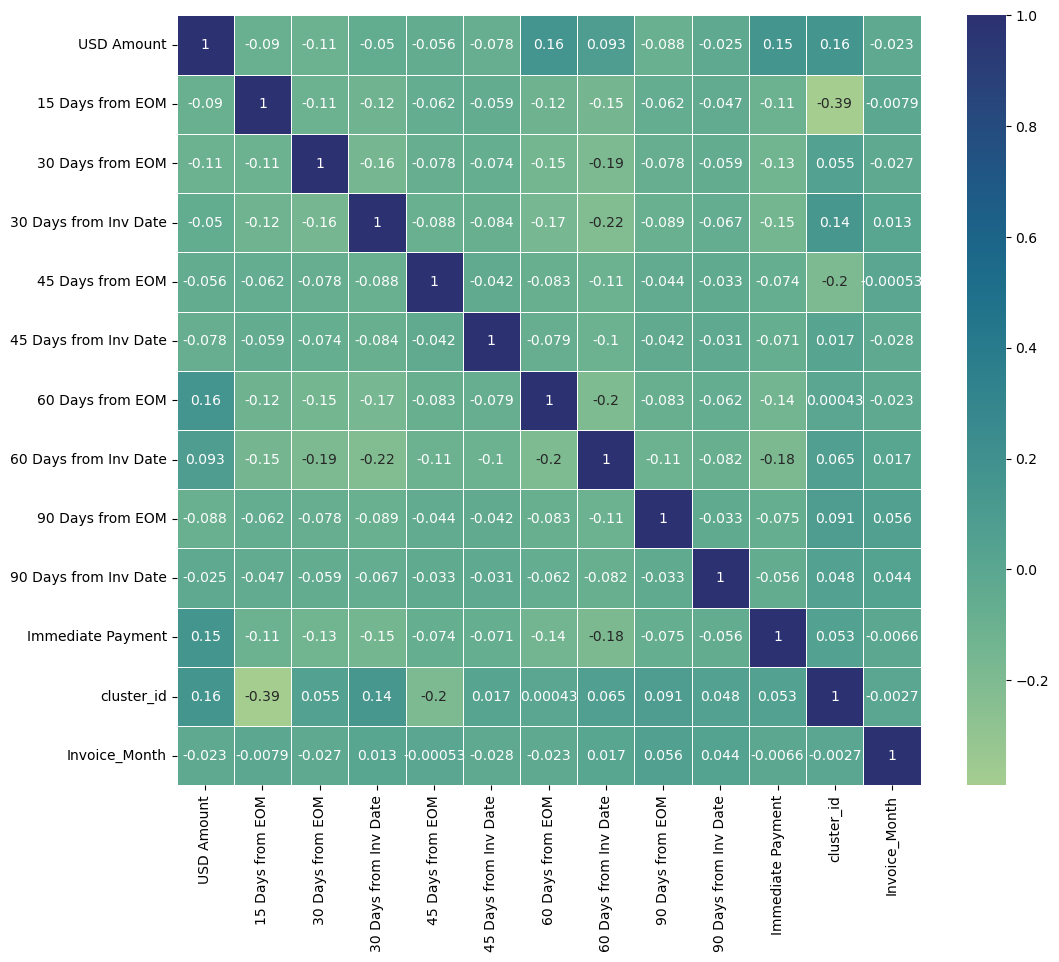

In [374]:
# Plotting heat map of X_train dataset again
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr(), annot=True,linewidths= 0.5 ,cmap= 'crest')
plt.show()

* Now the data has no high multicollinearity. Going ahead with model building

## Model Building

## Logistic Regression

In [376]:
# Importing required library for building logistic regression model
import statsmodels.api as sm

## 1st Model

In [379]:
X_train_sm = sm.add_constant(X_train)
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res=logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                64967
Model:                            GLM   Df Residuals:                    64953
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30146.
Date:                Thu, 06 Mar 2025   Deviance:                       60292.
Time:                        15:06:07   Pearson chi2:                 6.29e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3018
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.9566      0.052     18.559      0.000       0.856       1.058
USD Amount               -0.0342      0.012     -2.858      0.004      -0.058      -0.011
15 Days from EOM          2.4735      0.107     23.119      0.000       2.264       2.683
30 Days from EOM         -2.3400      0.053    -44.426      0.000      -2.443      -2.237
30 Days from Inv Date     0.2516      0.052      4.877      0.000       0.150       0.353
45 Days from EOM          0.3050      0.070      4.382      0.000       0.169       0.441
45 Days from Inv Date    -0.3133      0.063     -4.991      0.000      -0.436      -0.190
60 Days from EOM         -2.1698      0.052    -41.409      0.000      -2.272      -2.067
60 Days from Inv Date    -0.1936      0.049     -3.915      0.000      -0.291      -0.097
90 Days from EOM         -0.5079      0.061     -8.326      0.000      -0.627      -0.388
90 Days from Inv Date    -1.0336      0.069    -15.044      0.000      -1.168      -0.899
Immediate Payment         3.0961      0.104     29.705      0.000       2.892       3.300
cluster_id               -0.4368      0.026    -16.931      0.000      -0.487      -0.386
Invoice_Month             0.0952      0.003     37.574      0.000       0.090       0.100
=========================================================================================
"""

### Checking VIF

In [382]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,cluster_id,4.08
12,Invoice_Month,2.66
7,60 Days from Inv Date,2.01
3,30 Days from Inv Date,1.85
2,30 Days from EOM,1.58
6,60 Days from EOM,1.57
10,Immediate Payment,1.54
8,90 Days from EOM,1.29
5,45 Days from Inv Date,1.17
9,90 Days from Inv Date,1.15


* Both the p-value and VIF are in acceptable range, hence going ahead with this model.

In [385]:
# Predicted values for train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

52625    0.209960
29115    0.673845
80920    0.763726
55019    0.374863
82266    0.814366
16093    0.991638
54916    0.374863
15532    0.207595
2618     0.810537
79771    0.624812
dtype: float64

In [387]:
# Reshaping the array
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.20995955, 0.6738448 , 0.76372636, 0.37486271, 0.81436605,
       0.99163782, 0.37486271, 0.20759496, 0.8105375 , 0.62481234])

In [389]:
# Creating a dataframe for predicted values
y_pred = pd.DataFrame({'default':y_train.values, 'default_pred':y_train_pred})
y_pred.head()

,default,default_pred
0,0,0.209960
1,0,0.673845
2,1,0.763726
3,1,0.374863
4,0,0.814366


#### Creating a new column 'final_pred' if 'default_pred' > 0.5

In [393]:
# Making the prediction based on 0.5 cutoff
y_pred['logreg_pred'] = y_pred['default_pred'].map(lambda x:1 if x>0.5 else 0) 
y_pred.head()

,default,default_pred,logreg_pred
0,0,0.209960,0
1,0,0.673845,1
2,1,0.763726,1
3,1,0.374863,0
4,0,0.814366,1


In [395]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from statsmodels.tools.tools import add_constant

#### # Confusion Matrix

In [402]:
confusion = confusion_matrix(y_pred.default, y_pred.logreg_pred)
confusion

array([[12815,  9534],
       [ 4453, 38165]])

#### Accuracy

In [404]:
Accuracy = accuracy_score(y_pred.default, y_pred.logreg_pred)
Accuracy

0.7847060815490942

* We have 78.3% accuracy for our train data set.

In [410]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

#### Sensitivity

In [413]:
sensitivity = TP / float(TP+FN)
sensitivity

0.8955136327373411

#### Specificity

In [416]:
specificity = TN / float(TN+FP)
specificity

0.5734037317105911

In [418]:
# Calculate false postive rate
print(FP/ float(TN+FP))

0.42659626828940894


In [420]:
# positive predictive value 
print (TP / float(TP+FP))

0.8001215958405836


In [422]:
# Negative predictive value
print (TN / float(TN+ FN))

0.7421241602965022


### Finding the optimal cutoff point

In [425]:
# Trying out multiple threshold values
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    y_pred[f'y_pred_{i}'] = y_pred['default_pred'].apply(lambda x : 1 if x > i else 0)
y_pred

,default,default_pred,logreg_pred,y_pred_0.1,y_pred_0.2,y_pred_0.3,y_pred_0.4,y_pred_0.5,y_pred_0.6,y_pred_0.7,y_pred_0.8,y_pred_0.9
0,0,0.209960,0,1,1,0,0,0,0,0,0,0
1,0,0.673845,1,1,1,1,1,1,1,0,0,0
2,1,0.763726,1,1,1,1,1,1,1,1,0,0
3,1,0.374863,0,1,1,1,0,0,0,0,0,0
4,0,0.814366,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
64962,0,0.727069,1,1,1,1,1,1,1,1,0,0
64963,1,0.173788,0,1,0,0,0,0,0,0,0,0
64964,1,0.906623,1,1,1,1,1,1,1,1,1,1
64965,1,0.910813,1,1,1,1,1,1,1,1,1,1


In [427]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_pred.default, y_pred[f'y_pred_{i}'])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.1   0.1  0.655995  1.000000  0.000000
0.2   0.2  0.728924  0.976090  0.257595
0.3   0.3  0.767682  0.947745  0.424314
0.4   0.4  0.782551  0.911047  0.537518
0.5   0.5  0.784706  0.895514  0.573404
0.6   0.6  0.774039  0.864142  0.602219
0.7   0.7  0.730294  0.713173  0.762942
0.8   0.8  0.648422  0.498052  0.935165
0.9   0.9  0.540367  0.305364  0.988501


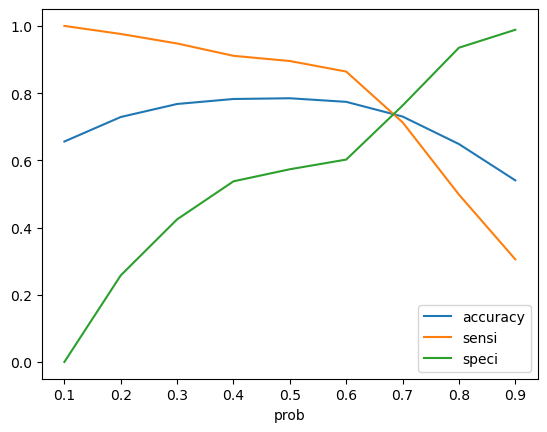

In [429]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

* From the curve above, 0.6 is the optimum point to take it as a cutoff probability.

In [432]:
# Creating a column based on 0.6 cutoff for prediction
y_pred['final_predicted'] = y_pred.default_pred.map( lambda x: 1 if x > 0.6 else 0)

y_pred.head()

,default,default_pred,logreg_pred,y_pred_0.1,y_pred_0.2,y_pred_0.3,y_pred_0.4,y_pred_0.5,y_pred_0.6,y_pred_0.7,y_pred_0.8,y_pred_0.9,final_predicted
0,0,0.209960,0,1,1,0,0,0,0,0,0,0,0
1,0,0.673845,1,1,1,1,1,1,1,0,0,0,1
2,1,0.763726,1,1,1,1,1,1,1,1,0,0,1
3,1,0.374863,0,1,1,1,0,0,0,0,0,0,0
4,0,0.814366,1,1,1,1,1,1,1,1,1,0,1


#### Accuracy Score

In [435]:
# Let's check the overall accuracy.
accuracy_score(y_pred.default, y_pred.final_predicted)

0.7740391275570674

#### Precision Score

In [439]:
precision_score(y_pred.default, y_pred.final_predicted)

0.8055470493022442

#### Recall Score

In [444]:
recall_score(y_pred.default, y_pred.final_predicted)

0.8641419118682246

In [446]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_pred.default, y_pred.default_pred)

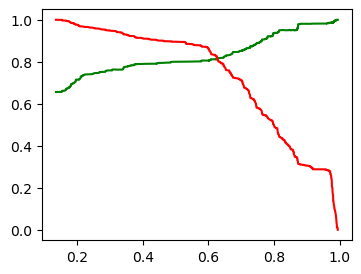

In [454]:
plt.figure(figsize=(4,3))
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

* On Precision & Recall trade off we found optimal cutoff of between 0.6 & 0.7 . Hence keeping the optimal cutoff 0.6.

### Plotting the ROC curve

In [458]:
from sklearn.metrics import roc_auc_score,roc_curve

In [460]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [462]:
fpr, tpr, thresholds = roc_curve(y_pred.default,y_pred.default_pred,drop_intermediate = False)

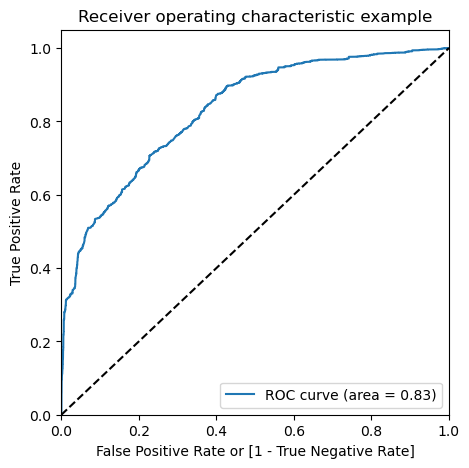

In [464]:
draw_roc(y_pred.default,y_pred.default_pred)

* AUC = 0.83 which shows the model is good.

### Making predictions on the test set

In [468]:
# Transforming the numerical column of test set
X_test[['USD Amount']]= scaler.transform(X_test[['USD Amount']])
X_test.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,cluster_id,Invoice_Month
12743,-0.545664,0,0,0,0,0,1,0,0,0,0,1,3
75338,-0.468936,0,0,0,0,0,0,1,0,0,0,0,8
39614,-0.391925,0,0,0,0,0,0,0,0,0,1,1,5
52529,-0.561789,0,1,0,0,0,0,0,0,0,0,1,5
47001,0.565237,0,1,0,0,0,0,0,0,0,0,0,4


In [470]:
# Adding a constant
X_test_sm = sm.add_constant(X_test)

In [472]:
# Making predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

12743    0.206578
75338    0.823595
39614    0.983783
52529    0.210007
47001    0.264681
90315    0.153713
28144    0.860252
29929    0.703567
80190    0.745296
1736     0.796665
dtype: float64

In [474]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [476]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [478]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [480]:
y_test_df.head()

,default,CustID
12743,0,12743
75338,1,75338
39614,1,39614
52529,0,52529
47001,0,47001


In [482]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [484]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [486]:
y_pred_final.head()

,default,CustID,0
0,0,12743,0.206578
1,1,75338,0.823595
2,1,39614,0.983783
3,0,52529,0.210007
4,0,47001,0.264681


In [488]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Delay_Prob','target':'Delay'})

In [490]:
# Let's see the head of y_pred_final
y_pred_final.head()

,default,CustID,Delay_Prob
0,0,12743,0.206578
1,1,75338,0.823595
2,1,39614,0.983783
3,0,52529,0.210007
4,0,47001,0.264681


In [492]:
# Creating final prediction on test set based on 0.6 cutoff
y_pred_final['final_predicted'] = y_pred_final.Delay_Prob.map(lambda x: 1 if x >= 0.6 else 0)

In [494]:
y_pred_final.head()

,default,CustID,Delay_Prob,final_predicted
0,0,12743,0.206578,0
1,1,75338,0.823595,1
2,1,39614,0.983783,1
3,0,52529,0.210007,0
4,0,47001,0.264681,0


#### Overall Accuracy

In [496]:
# Let's check the overall accuracy.
accuracy_score(y_pred_final.default, y_pred_final.final_predicted)

0.7758583536848154

#### Precision score

In [498]:
# Precision score
precision_score(y_pred_final.default, y_pred_final.final_predicted)

0.8077275971046998

#### Recall Score

In [500]:
# Recall Score
recall_score(y_pred.default, y_pred.final_predicted)

0.8641419118682246

* Our train and test accuracy is almost same around 77.5 %

## Random Forest

In [507]:
# importing necessary libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [511]:
df.columns

Index(['USD Amount', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'DM', 'INV', 'CM',
       'cluster_id', 'Invoice_Month'],
      dtype='object')

In [513]:
# creating X and y
X= df
y= merged_df['default']

In [515]:
# Splitting into train and test set
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.3, random_state=42)

In [517]:
# Building a base random forest model to check the accuracy

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

In [519]:
# Predicted values
y_train_pred_rf = rf.predict(X_train_rf)

In [521]:
# Checking accuracy and classification report
accuracy = accuracy_score(y_train_rf, y_train_pred_rf)
print(classification_report(y_train_rf, y_train_pred_rf))
print("Accuracy is : ", accuracy)

              precision    recall  f1-score   support

           0       0.96      0.91      0.94     22349
           1       0.96      0.98      0.97     42618

    accuracy                           0.96     64967
   macro avg       0.96      0.95      0.95     64967
weighted avg       0.96      0.96      0.96     64967

Accuracy is :  0.9580864131020365


In [523]:
# Using cross validation to check if our model is overfitting

rf_cv = RandomForestClassifier(random_state=42)

# Compute cross-validation scores on the training data
scores = cross_val_score(rf_cv, X_train_rf, y_train_rf, cv=5, scoring= 'recall')

# Compute the mean and standard deviation of the cross-validation scores
mean_score = scores.mean()
std_score = scores.std()

# Print the mean and standard deviation of the cross-validation scores
print("Mean score:", mean_score)
print("Standard deviation:", std_score)

Mean score: 0.9520624293565543
Standard deviation: 0.0015914040846447776


In [525]:
# Creating y_pred for test data
y_test_pred_rf = rf.predict(X_test_rf)

In [527]:
# Checking accuracy and classification report of test data
accuracy = accuracy_score(y_test_rf, y_test_pred_rf)
print(classification_report(y_test_rf, y_test_pred_rf))
print("Accuracy is : ", accuracy)

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      9529
           1       0.93      0.96      0.94     18315

    accuracy                           0.92     27844
   macro avg       0.92      0.91      0.91     27844
weighted avg       0.92      0.92      0.92     27844

Accuracy is :  0.9217066513431978


### Hyperparameter Tuning

In [530]:
# Using Grid search for hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20,30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid=param_grid, scoring='f1', cv=5, n_jobs= -1)

grid_search.fit(X_train_rf, y_train_rf)

# Best Hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best f1 score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_cv_rf = best_rf.predict(X_train_rf)

print(classification_report(y_train_rf, y_pred_cv_rf))

Best hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best f1 score: 0.9393260434851571
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     22349
           1       0.96      0.98      0.97     42618

    accuracy                           0.96     64967
   macro avg       0.96      0.95      0.95     64967
weighted avg       0.96      0.96      0.96     64967



In [532]:
# Test set (testing)

y_pred_test_cv = best_rf.predict(X_test_rf)

print(classification_report(y_test_rf,y_pred_test_cv))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      9529
           1       0.93      0.96      0.94     18315

    accuracy                           0.92     27844
   macro avg       0.92      0.91      0.91     27844
weighted avg       0.92      0.92      0.92     27844



From the above classification report, it can be seen that the f1-score for train and test set is 0.97 and 0.96, which implies that this is a good model. Hence moving forward with this as final model for prediction.

### Checking feature importance

In [536]:
importance = best_rf.feature_importances_
sorted_id = importance.argsort()[::-1]

# Print the feature ranking
print("Feature ranking:")
for i, id in enumerate(sorted_id):
    print(f"{i+1}. {X.columns[id]} ({importance[id]:.3f})")

Feature ranking:
1. USD Amount (0.491)
2. Invoice_Month (0.129)
3. 30 Days from EOM (0.114)
4. 60 Days from EOM (0.111)
5. Immediate Payment (0.041)
6. 15 Days from EOM (0.028)
7. cluster_id (0.027)
8. 60 Days from Inv Date (0.013)
9. 30 Days from Inv Date (0.011)
10. 90 Days from Inv Date (0.008)
11. INV (0.007)
12. 90 Days from EOM (0.007)
13. 45 Days from EOM (0.005)
14. CM (0.004)
15. 45 Days from Inv Date (0.004)
16. DM (0.001)


### Preparing Open Invoice dataset for prediction

The AGE column in the open invoice data, calculated as the difference between the Transaction Date and AS_OF_DATE, indicates payment status. A positive AGE signifies overdue payments, requiring no prediction. Conversely, a negative AGE reflects pending due dates, representing invoices still within the payment window. The model should focus on predicting payment delays exclusively for customers with negative AGE values, as these cases present actionable insights for mitigating potential late payments. By targeting this subset, the model enhances its relevance and effectiveness in forecasting payment behavior for invoices where the due date has not yet been crossed.

In [542]:
# Selecting rows with negative age value for prediction
df_age = open_data[open_data['AGE'] < 0]
df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM
2,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0
4,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0
5,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0
6,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0
7,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0


In [544]:
df_age = pd.merge(df_age, cust_dict, how='left', on='Customer_Name')

In [546]:
# Null counts
round(df_age.isna().sum()/len(df_age.index), 4)

Customer_Name            0.0000
Due Date                 0.0000
AGE                      0.0000
USD Amount               0.0000
INV_CREATION_DATE        0.0000
15 Days from EOM         0.0000
30 Days from EOM         0.0000
30 Days from Inv Date    0.0000
45 Days from EOM         0.0000
45 Days from Inv Date    0.0000
60 Days from EOM         0.0000
60 Days from Inv Date    0.0000
90 Days from EOM         0.0000
90 Days from Inv Date    0.0000
Immediate Payment        0.0000
DM                       0.0000
INV                      0.0000
CM                       0.0000
cluster_id               0.0274
dtype: float64

* cluster_id has 2.7 % null value counts, hence removing the null values for better model prediction as these null values are of new customers whose data is not present in the 'Received Payment data'.

In [549]:
# Dropping the rows containing null values
df_age.dropna(axis=0, inplace=True)

In [551]:
df_age.shape

(27247, 19)

In [553]:
df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id
0,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,1.0
1,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0
2,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0
3,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0
4,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0


In [555]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27247 entries, 0 to 28014
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Customer_Name          27247 non-null  object        
 1   Due Date               27247 non-null  datetime64[ns]
 2   AGE                    27247 non-null  int64         
 3   USD Amount             27247 non-null  int64         
 4   INV_CREATION_DATE      27247 non-null  datetime64[ns]
 5   15 Days from EOM       27247 non-null  int64         
 6   30 Days from EOM       27247 non-null  int64         
 7   30 Days from Inv Date  27247 non-null  int64         
 8   45 Days from EOM       27247 non-null  int64         
 9   45 Days from Inv Date  27247 non-null  int64         
 10  60 Days from EOM       27247 non-null  int64         
 11  60 Days from Inv Date  27247 non-null  int64         
 12  90 Days from EOM       27247 non-null  int64         
 13  90 Day

In [557]:
# converting the cluster_id column to int
df_age['cluster_id'] = df_age['cluster_id'].astype('Int64')

In [559]:
# Checking the head after adding 'cluster_id' column
df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id
0,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1
2,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1
3,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1
4,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1


In [561]:
# Creating a copy of open_reg_df_age for final prediction
df_final = df_age.copy()

In [563]:
# Dropping Customer_Name and AGE column
df_final.drop(['Customer_Name', 'AGE'], axis=1, inplace=True)

In [565]:
df_final['Invoice_Month'] = df_final['INV_CREATION_DATE'].dt.month # Extracting Month

In [567]:
# Dropping due_date and invoice creation date

df_final.drop(['Due Date','INV_CREATION_DATE'], axis= 1, inplace= True)

In [569]:
# Checking the columns in the dataset
df_final.columns

Index(['USD Amount', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'DM', 'INV', 'CM',
       'cluster_id', 'Invoice_Month'],
      dtype='object')

### Final Prediction based on Random Forest model

In [572]:
# getting predictions on open invoices

y_open_invoices= best_rf.predict_proba(df_final)[:,1]

y_open_invoices

array([0.98933885, 0.9431746 , 0.84099099, ..., 0.9       , 0.96944444,
       0.36596154])

In [574]:
# Adding the predicted values to the dataframe
df_age['Pred_rf'] = y_open_invoices
df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Pred_rf
0,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0.989339
1,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0.943175
2,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0.840991
3,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0.000000
4,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0.986667


In [582]:
# Customer-wise model prediction
customer_seg_prob = pd.DataFrame(df_age.groupby('Customer_Name')['Pred_rf'].prod().round(4))
customer_seg_prob

,Pred_rf
Customer_Name,
3D D Corp,0.0000
6TH Corp,0.0000
ABDU Corp,0.0000
ABEE Corp,0.2434
ABU Corp,0.0014
ABWA Corp,0.0483
AFAQ Corp,0.0000
AFRI Corp,0.2306
AG L Corp,0.9439


In [584]:
# Taking 0.6 as cut off value
df_age['Final_Prediction'] = df_age.Pred_rf.map(lambda x: 1 if x>0.6 else 0)

In [586]:
# Let us check our final dataframe with predictions
df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Pred_rf,Final_Prediction
0,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0.989339,1
1,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0.943175,1
2,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0.840991,1
3,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0.000000,0
4,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0.986667,1


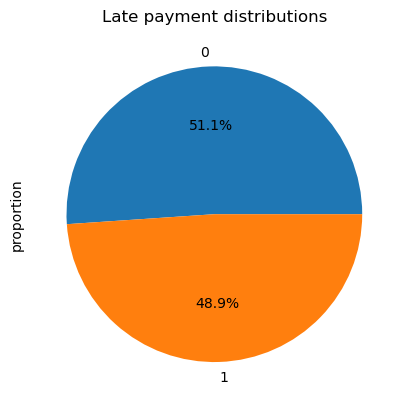

In [588]:
# Visualization
(df_age.Final_Prediction.value_counts(normalize = True)*100).plot.pie(autopct='%1.1f%%')
plt.title("Late payment distributions")
plt.show()

##### From the above pie chart, we can observe that 50.2% payments in the open invoice data with AGE value negative(indicating due date not crossed)

### Summary of prediction on Customers_name

In [592]:
# Checking Customers with our target variable_delayed
Delay_payment = df_age.groupby(['Customer_Name'])['Final_Prediction'].sum()
Delay_payment = Delay_payment.to_frame()
Delay_payment = Delay_payment.sort_values(by ='Final_Prediction',ascending=False)

In [596]:
# Checking Customers for total invoice counts
Delay_payment_total = df_age.groupby(['Customer_Name'])['Final_Prediction'].count() # total payments by each customers
Delay_payment_total = Delay_payment_total.to_frame()
Delay_payment_total = Delay_payment_total.sort_values(by ='Final_Prediction',ascending=False)

In [598]:
# Merging both dataframes based on Customer_name
Merge_df=pd.merge(Delay_payment,Delay_payment_total,how='inner',on='Customer_Name')

In [600]:
# Renaming the columns
Merge_df.columns=["Delayed_Payment","Total_Payments"]

In [602]:
# Creating a column for delay percentage of each customers
Merge_df['Delay%']=np.round(Merge_df['Delayed_Payment']/Merge_df['Total_Payments']*100,2)

In [604]:
# Checking Merge_df 
Merge_df.sort_values('Total_Payments',ascending=False)

,Delayed_Payment,Total_Payments,Delay%
Customer_Name,,,
SEPH Corp,3674,8260,44.48
FITR Corp,1445,3454,41.84
PARF Corp,1143,1717,66.57
AREE Corp,784,1117,70.19
ALLI Corp,355,1042,34.07
DEBE Corp,321,654,49.08
AL T Corp,391,584,66.95
HABC Corp,337,517,65.18
RADW Corp,214,490,43.67


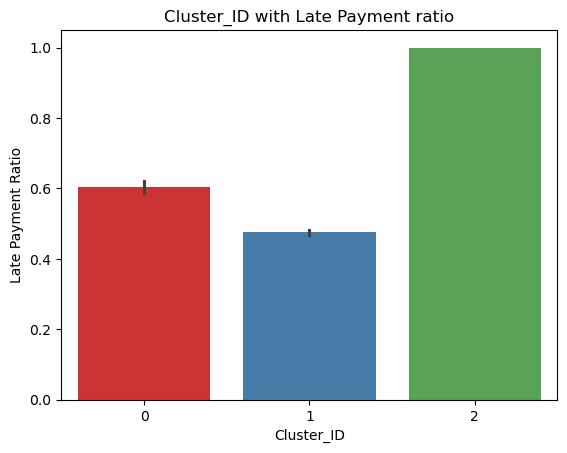

In [606]:
# Visualization
sns.barplot(data=df_age, x='cluster_id', y='Final_Prediction', estimator=np.mean, palette='Set1')
plt.title("Cluster_ID with Late Payment ratio")
plt.xlabel("Cluster_ID")
plt.ylabel("Late Payment Ratio")
plt.show()
#cluster ID 1 has significantly higher ratio of default than clusters 0 and 2

In [608]:
# Top 10 customers with highest delay rate
Merge_df.sort_values(['Delay%','Total_Payments','Delayed_Payment'],ascending=[False,False,False]).head(10) 

,Delayed_Payment,Total_Payments,Delay%
Customer_Name,,,
IL G Corp,13,13,100.0
RNA Corp,9,9,100.0
SHIS Corp,8,8,100.0
ALSU Corp,7,7,100.0
LVMH Corp,4,4,100.0
FINA Corp,4,4,100.0
V PE Corp,4,4,100.0
TRAF Corp,3,3,100.0
MAYC Corp,3,3,100.0


## Recommendations based on the derived insights:

#### From our clustering analysis we can make the following inference :-
* Credit Note payments experience the highest delay rates compared to Debit Note or Invoice categories. As a result, it may be advisable for the company to implement stricter payment collection policies specifically for Credit Note invoices.
  
* Invoices related to goods exhibit significantly higher payment delay rates compared to non-goods invoices. Therefore, it would be prudent to implement stricter payment policies for goods-related invoices.
  
* Given that lower-value payments constitute the majority of transactions and are also more prone to delays, it is recommended that the company place greater emphasis on managing these payments. A tiered penalty system could be introduced, where the penalty percentage for late payments increases in relation to the lower billing amount. However, this approach should be considered a last resort and applied with caution.
  
* Customer segments were classified into three categories: 0, 1, and 2, representing medium, prolonged, and early payment durations, respectively. Analysis revealed that customers in cluster 1 (prolonged payment duration) exhibited significantly higher delay rates compared to those in the early and medium payment categories. Therefore, it is recommended that greater attention and focus be directed towards managing the payment behaviors of cluster 1 customers.
  
* Companies with the highest probability of delayed payments, as well as the greatest total and delayed payment counts, should be prioritized for attention. Given the high probability of delays, these companies warrant focused efforts to address payment issues effectively.